# Table of Contents: <a class="anchor" id="contents"></a> 

* [Importing and cleaning data](#import)
* [Descriptive Stats](#descr)
* [Logistic Regression RFE](#logisticrfe)
    * [HNHC](#lrhnhc)
    * [HNHC no 'los'](#lrhnhcnolos)
    * [IBD_READM](#lrreadm)
    * [IBD_READM no 'los'](#lrreadmnolos)
* [Decision Tree RFE](#decisiontreerfe)
    * [HNHC](#dthnhc)
    * [HNHC no 'los'](#dthnhcnolos)
    * [IBD_READM](#dtreadm)
    * [IBD_READM no 'los'](#dtreadmnolos)
* [XGBoost RFE](#xgboostrfe)
    * [HNHC](#xgbhnhc)
    * [HNHC no 'los'](#xgbhnhcnolos)
    * [IBD_READM](#xgbreadm)
    * [IBD_READM no 'los'](#xgbreadmnolos)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree
import pandas as pd
import numpy as np
import os
import warnings
import timeit
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
# Read in the data as a dataframe.
df = pd.read_csv('NRD 2013 (machine learning).csv')
df.head()

3              3               0   
3              1            1              1               1   
4              5            1              5               1   

   ibd_index_six_months  ibd_index_death  ibd_index_after_june  \
0                   1.0              NaN                   NaN   
1                   NaN              NaN                   NaN   
2                   NaN              NaN                   NaN   
3                   1.0              NaN                   NaN   
4                   1.0              NaN                   NaN   

   ibd_index_flag_exclude  ibd_min_dmonth  ibd_total_los  dmonth_dead  \
0                     NaN             3.0           21.0            0   
1                     NaN             NaN           21.0            0   
2                     NaN             NaN           21.0            0   
3                     NaN             6.0            4.0            0   
4                     NaN             5.0           34.0            0   

   dmonth_dead_fu  ibd_fu_v1  ibd_fu_v2  ibd_alive_fu  before_ibd_index_adm  \
0               0         10         10            10                   NaN   
1               0          0         10            10                   NaN   
2               0          0         10            10                   NaN   
3               0          7          7             7                   NaN   
4               0          8          8             8                   NaN   

   total_before_ibd_index  before_ibd_index  ibdtotaladm_from_index  \
0                       0                 0                       3   
1                       0                 0                       3   
2                       0                 0                       3   
3                       0                 0                       1   
4                       0                 0                       5   

   ibdtotlos_alive_fu  ibdtotadm_alive_fu  ibd_total_charges  \
0            2.100000            0.300000          52107.672   
1                 NaN                 NaN          52107.672   
2                 NaN                 NaN          52107.672   
3            0.571429            0.142857          10820.521   
4            4.250000            0.625000          41874.746   

   ibdtotcharges_alive_fu  age_group  young_quintile  young_quintile_flag  \
0               5210.7671          2               0                  0.0   
1                     NaN          2               0                  0.0   
2                     NaN          2               0                  0.0   
3               1545.7887          1               0                  0.0   
4               5234.3433          2               0                  0.0   

   sum_young  middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
0      85151                0                   0.0      114990             1   
1      85151                0                   0.0      114990             1   
2      85151                0                   0.0      114990             1   
3      85151                1                   1.0      114990             0   
4      85151                0                   0.0      114990             1   

   old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
0                3.0    79516                 NaN                  NaN   
1                3.0    79516                 NaN                  NaN   
2                3.0    79516                 NaN                  NaN   
3                0.0    79516                 NaN                  2.0   
4                5.0    79516                 NaN                  NaN   

   ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
0               4.0            0.0                         0   
1               NaN            0.0                         0   
2               NaN            0.0                         0   
3               NaN            0.0                         1 

In [3]:
# Create a list of the column names and print it out.
variables = df.columns.values
print(variables)

['index' 'age' 'aweekend' 'died' 'discwt' 'dispuniform' 'dmonth' 'dqtr'
 'drg' 'drgver' 'drg_nopoa' 'dx1' 'dx2' 'dx3' 'dx4' 'dx5' 'dx6' 'dx7'
 'dx8' 'dx9' 'dx10' 'dx11' 'dx12' 'dx13' 'dx14' 'dx15' 'dx16' 'dx17'
 'dx18' 'dx19' 'dx20' 'dx21' 'dx22' 'dx23' 'dx24' 'dx25' 'dxccs1' 'dxccs2'
 'dxccs3' 'dxccs4' 'dxccs5' 'dxccs6' 'dxccs7' 'dxccs8' 'dxccs9' 'dxccs10'
 'dxccs11' 'dxccs12' 'dxccs13' 'dxccs14' 'dxccs15' 'dxccs16' 'dxccs17'
 'dxccs18' 'dxccs19' 'dxccs20' 'dxccs21' 'dxccs22' 'dxccs23' 'dxccs24'
 'dxccs25' 'elective' 'female' 'hcup_ed' 'hosp_nrd' 'key_nrd' 'los' 'mdc'
 'mdc_nopoa' 'nchronic' 'ndx' 'necode' 'npr' 'nrd_daystoevent'
 'nrd_stratum' 'nrd_visitlink' 'orproc' 'pay1' 'pl_nchs' 'pr1' 'pr2' 'pr3'
 'pr4' 'pr5' 'pr6' 'pr7' 'pr8' 'pr9' 'pr10' 'pr11' 'pr12' 'pr13' 'pr14'
 'pr15' 'prccs1' 'prccs2' 'prccs3' 'prccs4' 'prccs5' 'prccs6' 'prccs7'
 'prccs8' 'prccs9' 'prccs10' 'prccs11' 'prccs12' 'prccs13' 'prccs14'
 'prccs15' 'rehabtransfer' 'resident' 'samedayevent' 'totchg' 'year'
 'zip

In [4]:
# Look at the ibd_specific_adm column
df['ibd_specific_adm']

0        0
1        0
2        0
3        1
4        1
        ..
94493    1
94494    0
94495    0
94496    0
94497    1
Name: ibd_specific_adm, Length: 94498, dtype: int64

In [5]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

3              3               0   
3              1            1              1               1   
4              5            1              5               1   

   ibd_index_six_months  ibd_index_death  ibd_index_after_june  \
0                   1.0              NaN                   NaN   
1                   NaN              NaN                   NaN   
2                   NaN              NaN                   NaN   
3                   1.0              NaN                   NaN   
4                   1.0              NaN                   NaN   

   ibd_index_flag_exclude  ibd_min_dmonth  ibd_total_los  dmonth_dead  \
0                     NaN             3.0           21.0            0   
1                     NaN             NaN           21.0            0   
2                     NaN             NaN           21.0            0   
3                     NaN             6.0            4.0            0   
4                     NaN             5.0           34.0            0   

   dmonth_dead_fu  ibd_fu_v1  ibd_fu_v2  ibd_alive_fu  before_ibd_index_adm  \
0               0         10         10            10                   NaN   
1               0          0         10            10                   NaN   
2               0          0         10            10                   NaN   
3               0          7          7             7                   NaN   
4               0          8          8             8                   NaN   

   total_before_ibd_index  before_ibd_index  ibdtotaladm_from_index  \
0                       0                 0                       3   
1                       0                 0                       3   
2                       0                 0                       3   
3                       0                 0                       1   
4                       0                 0                       5   

   ibdtotlos_alive_fu  ibdtotadm_alive_fu  ibd_total_charges  \
0            2.100000            0.300000          52107.672   
1                 NaN                 NaN          52107.672   
2                 NaN                 NaN          52107.672   
3            0.571429            0.142857          10820.521   
4            4.250000            0.625000          41874.746   

   ibdtotcharges_alive_fu  age_group  young_quintile  young_quintile_flag  \
0               5210.7671          2               0                  0.0   
1                     NaN          2               0                  0.0   
2                     NaN          2               0                  0.0   
3               1545.7887          1               0                  0.0   
4               5234.3433          2               0                  0.0   

   sum_young  middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
0      85151                0                   0.0      114990             1   
1      85151                0                   0.0      114990             1   
2      85151                0                   0.0      114990             1   
3      85151                1                   1.0      114990             0   
4      85151                0                   0.0      114990             1   

   old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
0                3.0    79516                 NaN                  NaN   
1                3.0    79516                 NaN                  NaN   
2                3.0    79516                 NaN                  NaN   
3                0.0    79516                 NaN                  2.0   
4                5.0    79516                 NaN                  NaN   

   ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
0               4.0            0.0                         0   
1               NaN            0.0                         0   
2               NaN            0.0                         0   
3               NaN            0.0                         1 

In [6]:
# Check the back end of the data
df_copy.tail()

11   

       ibd_alive_fu  before_ibd_index_adm  total_before_ibd_index  \
94493             7                   NaN                       0   
94494             7                   NaN                       0   
94495             7                   NaN                       0   
94496            11                   NaN                       0   
94497            11                   NaN                       0   

       before_ibd_index  ibdtotaladm_from_index  ibdtotlos_alive_fu  \
94493                 0                       3            2.571429   
94494                 0                       3                 NaN   
94495                 0                       3                 NaN   
94496                 0                       1            0.181818   
94497                 0                       1            0.363636   

       ibdtotadm_alive_fu  ibd_total_charges  ibdtotcharges_alive_fu  \
94493            0.428571         58356.2970              8336.61430   
94494                 NaN         58356.2970                     NaN   
94495                 NaN         58356.2970                     NaN   
94496            0.090909         15479.2880              1407.20800   
94497            0.090909          5843.7397               531.24908   

       age_group  young_quintile  young_quintile_flag  sum_young  \
94493          1               0                  0.0      85151   
94494          1               0                  0.0      85151   
94495          1               0                  0.0      85151   
94496          1               0                  0.0      85151   
94497          2               0                  0.0      85151   

       middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
94493                1                   3.0      114990             0   
94494                1                   3.0      114990             0   
94495                1                   3.0      114990             0   
94496                1                   1.0      114990             0   
94497                0                   0.0      114990             1   

       old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
94493                0.0    79516                 NaN                  4.0   
94494                0.0    79516                 NaN                  NaN   
94495                0.0    79516                 NaN                  NaN   
94496                0.0    79516                 NaN                  1.0   
94497                1.0    79516                 NaN                  NaN   

       ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
94493               NaN            0.0                         1   
94494               NaN            0.0                         1   
94495               NaN            0.0                         0   
94496               NaN            0.0                         0   
94497               2.0            0.0                         0   

       blood_transfusion  parenteral_or_enteral_index  ibd_procedures  \
94493                  1                            0               1   
94494                  0                            0               1   
94495                  0                            0               0   
94496                  0                            0               0   
94497                  0                            0               0   

       tot_gi_or_hepatic_proc  max_nrd_daystoevent  ibd_max_daystoevent  \
94493                     1.0              14600.0                14600   
94494                     1.0                  NaN                14600   
94495                     1.0                  NaN                14600   
94496                     0.0              17978.0                17978   
94497                     0.0              22167.0                22167   

       ibd_readm  ibd_tot_readm  ibd_net_readm  ibd_colostomy_adm  \
94493          0           

In [7]:
# Check the data 
# Looks like the ibd_readm variables contains "NA" values

df_copy[['nrd_visitlink','ibd_index_hosp', 'dx1', 'new_mi_adm', 'ibd_readm']].head()

nrd_visitlink  ibd_index_hosp    dx1  new_mi_adm  ibd_readm
0        00017u               1  00845           0          0
1        00017u               0   0389           0          1
2        00017u               0  03842           0          1
3        0004o5               1   5559           0          0
4        000dbz               1   5559           0          0

In [8]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','ibd_readm']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = '1'
df_copy[['nrd_visitlink','ibd_index_hosp', 'ibd_readm']].head(15)

nrd_visitlink  ibd_index_hosp ibd_readm
0         00017u               1         1
1         00017u               0         1
2         00017u               0         1
3         0004o5               1         0
4         000dbz               1         1
5         000dbz               0         1
6         000dbz               0         1
7         000dbz               0         1
8         000dbz               0         1
9         000mgu               1         0
10        0018do               1         0
11        001nun               1         1
12        001nun               0         1
13        001nun               0         1
14        001nun               0         1

In [9]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hosp', 'ibd_readm']].head(15)

nrd_visitlink  pay1  ibd_index_hosp ibd_readm
0         00017u   1.0               1         1
1         00017u   1.0               0         1
2         00017u   1.0               0         1
3         0004o5   3.0               1         0
4         000dbz   1.0               1         1
5         000dbz   1.0               0         1
6         000dbz   1.0               0         1
7         000dbz   1.0               0         1
8         000dbz   1.0               0         1
9         000mgu   3.0               1         0
10        0018do   2.0               1         0
11        001nun   2.0               1         1
12        001nun   2.0               0         1
13        001nun   2.0               0         1
14        001nun   2.0               0         1

In [10]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hosp'].value_counts()
index_hosp_counts

1    47402
0    47096
Name: ibd_index_hosp, dtype: int64

In [11]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    64373
0    30125
Name: ibd_readm, dtype: int64

In [12]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hosp"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hosp"].count()

47402

In [13]:
# Creating deciles by length of follow-up normalized by number of hospitalizations 
readm_data_df['ibd_deciles'] = pd.qcut(readm_data_df['ibdtotlos_alive_fu'], 10, labels=np.arange(10, 0, -1))

readm_data_df.head(15)

0   
19                     0                     0                  0   
22                     0                     0                  0   
23                     0                     0                  0   
30                     0                     0                  0   
31                     0                     0                  0   
32                     0                     0                  0   
33                     0                     0                  0   
38                     0                     0                  0   
39                     0                     0                  0   

    new_pyelonephritis_adm  new_osteo_adm  new_septicemia_adm  new_cdiff_adm  \
0                        0              0                   0              1   
3                        0              0                   0              0   
4                        0              0                   0              0   
9                        0              0                   0              0   
10                       0              0                   0              0   
11                       0              0                   0              0   
19                       0              0                   0              0   
22                       0              0                   1              0   
23                       0              0                   0              0   
30                       0              1                   1              0   
31                       0              0                   0              0   
32                       0              0                   0              0   
33                       0              0                   0              0   
38                       0              0                   0              0   
39                       0              0                   0              0   

    new_tb_adm  new_atypicalmyco_adm  new_fungal_adm  new_listeriosis_adm  \
0            0                     0               0                    0   
3            0                     0               0                    0   
4            0                     0               0                    0   
9            0                     0               0                    0   
10           0                     0               0                    0   
11           0                     0               0                    0   
19           0                     0               0                    0   
22           0                     0               0                    0   
23           0                     0               0                    0   
30           0                     0               0                    0   
31           0                     0               0                    0   
32           0                     0               0                    0   
33           0                     0               0                    0   
38           0                     0               0                    0   
39           0                     0               0                    0   

    new_leishmaniasis_adm  new_pcp_adm  chronic_pain  ibd_surgery_adm  \
0                       0            0             0                0   
3                       0            0             0                0   
4                       0            0             0                0   
9                       0            0             0                0   
10                      0            0             0                0   
11                      0            0             0                0   
19                      0            0             0                0   
22                      0            0             0                0   
23                      0            0             0                0   
30                      0            0             0                0   
31                      0            0             0    

In [14]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [15]:
# Generate a new variable to identify high-need, high-cost patients

def topDecile(series):
    if series == 1:
        return 1
    else:
        return 0
        
readm_data_df['hnhc_patients'] = readm_data_df['ibd_deciles'].apply(topDecile)

readm_data_df.tail(25)

0         0          0                 0   
94497          0       0       0         0          0                 0   

       fracture_adm  thrombosis_adm  ibd_specific_adm  others_adm  \
94449             0               0                 1           0   
94451             0               0                 0           0   
94452             0               0                 0           0   
94455             0               0                 0           0   
94456             0               0                 0           0   
94457             0               0                 0           0   
94459             0               0                 1           0   
94461             0               0                 0           0   
94462             0               0                 1           0   
94465             0               0                 0           0   
94466             0               0                 0           0   
94467             0               0                 0           0   
94468             1               0                 0           0   
94469             0               0                 0           0   
94470             0               0                 0           0   
94471             0               0                 0           0   
94472             0               0                 0           0   
94480             0               0                 0           0   
94482             0               0                 1           0   
94484             0               0                 0           0   
94491             0               0                 0           0   
94492             0               0                 0           0   
94493             0               0                 1           0   
94496             0               0                 0           0   
94497             0               0                 1           0   

       ibd_index_discharge_date  readmission_time  was_readmitted  \
94449                     19386               0.0               0   
94451                     14100               0.0               0   
94452                     20791               0.0               1   
94455                     14469               0.0               0   
94456                     16999               0.0               0   
94457                     15291               0.0               1   
94459                     18643               0.0               0   
94461                     20003               0.0               0   
94462                     15447               0.0               1   
94465                     12266               0.0               0   
94466                     15745               0.0               0   
94467                     25800               0.0               0   
94468                     18828               0.0               0   
94469                     14347               0.0               0   
94470                     22013               0.0               0   
94471                     17549               0.0               0   
94472                     16040               0.0               1   
94480                     14515               0.0               0   
94482                     18898               0.0               0   
94484                     12063               0.0               1   
94491                     12049               0.0               0   
94492                     12691               0.0               0   
94493                     14609               0.0               1   
94496                     17980               0.0               0   
94497                     22171               0.0               0   

       died_in_sixmo  did_die_in_sixmo  unplanned_in_sixmo  \
94449              0                 0                   0   
94451              0                 0                   0   
94452              0                 0                   0   
94455              0                 0    

In [16]:
# Create new features using isin function

# steroid use - V5865
readm_data_df['steroid_use'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['V5865']).any(axis=1).astype(int)

# abdominal pain - 78900
readm_data_df['abd_pain_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['78900']).any(axis=1).astype(int)

# acute kidney injury - 5849
readm_data_df['aki_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5849']).any(axis=1).astype(int)

# gi bleed - 5789
readm_data_df['gi_bleed_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5789']).any(axis=1).astype(int)

readm_data_df.head(25)


0             0   
58       0         0          0                 0             0   

    thrombosis_adm  ibd_specific_adm  others_adm  ibd_index_discharge_date  \
0                0                 0           0                     14072   
3                0                 1           0                     20504   
4                0                 1           0                     10837   
9                0                 0           0                     13862   
10               0                 0           0                     13346   
11               0                 0           0                     19113   
19               0                 0           0                     17868   
22               0                 0           0                     22230   
23               0                 0           0                     17637   
30               0                 0           0                     19448   
31               0                 1           0                     15831   
32               0                 0           0                     19987   
33               0                 0           1                     13414   
38               0                 1           0                     16560   
39               0                 1           0                     12707   
40               0                 0           0                     18568   
41               0                 1           0                     20672   
42               0                 0           0                     22879   
43               0                 0           0                     11087   
46               0                 0           0                     12267   
47               0                 0           0                     20406   
51               0                 0           0                     20401   
55               0                 0           0                     18195   
56               0                 1           0                     14747   
58               0                 0           0                     18702   

    readmission_time  was_readmitted  died_in_sixmo  did_die_in_sixmo  \
0                0.0               1              0                 0   
3                0.0               0              0                 0   
4                0.0               1              0                 0   
9                0.0               0              0                 0   
10               0.0               0              0                 0   
11               0.0               1              0                 0   
19               0.0               1              0                 0   
22               0.0               0              0                 0   
23               0.0               1              0                 0   
30               0.0               0              0                 0   
31               0.0               0              0                 0   
32               0.0               0              0                 0   
33               0.0               1              0                 0   
38               0.0               0              0                 0   
39               0.0               0              0                 0   
40               0.0               0              0                 0   
41               0.0               0              0                 0   
42               0.0               0              0                 0   
43               0.0               1              0                 0   
46               0.0               0              0                 0   
47               0.0               1              0                 0   
51               0.0               1              0                 0   
55               0.0               0              0                 0   
56               0.0               1              0                 0   
58               0.0               1              0        

In [17]:
# Intially run with entire feature list so RFE can use backwards selection to pick top features
data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm',
 'age',
 'female',
 'los',
 'aweekend',
 'elective',
 'orproc',
 'hosp_urban_rural_location',
 'payer',
 'zipinc_qrtl',
 'severe_IBD_hospitalization',
 'cm_aids',
 'cm_alcohol',
 'cm_anemdef',
 'cm_arth',
 'cm_bldloss',
 'cm_chf',
 'cm_chrnlung',
 'cm_depress',
 'cm_coag',
 'cm_dm',
 'cm_dmcx',
 'cm_drug',
 'cm_htn_c',
 'cm_hypothy',
 'cm_liver',
 'cm_lymph',
 'cm_lytes',
 'cm_mets',
 'cm_neuro',
 'cm_obese',
 'cm_para',
 'cm_perivasc',
 'cm_psych',
 'cm_pulmcirc',
 'cm_renlfail',
 'cm_tumor',
 'cm_ulcer',
 'cm_valve',
 'cm_wghtloss',
 'diabetes',
 'copd',
 'cm_smoking',
 'blood_transfusion',
 'ibd_procedures',
 'cc_index',
 'new_cc_index',
 'fractures',
 'thromboses',
 'unplanned_adm',
 'pq1_dm_short',
 'pq2_perf_appendix',
 'pq3_dm_long',
 'pq5_copd_asthma',
 'pq7_htn',
 'pq8_chf',
 'pq10_dehydrate',
 'pq11_bacterialpna',
 'pq12_uti',
 'pq13_angina',
 'pq14_diabeteswocomp',
 'pq15_asthma',
 'pq16_dm_amputate',
 'new_mi_adm',
 'new_chf_adm',
 'new_unstableangina_adm',
 'new_arrhythmia_adm',
 'new_cardiacarrest_adm',
 'new_meningitis_adm',
 'new_encephalitis_adm',
 'new_endocarditis_adm',
 'new_pneumonia_adm',
 'new_pyelonephritis_adm',
 'new_osteo_adm',
 'new_septicemia_adm',
 'new_cdiff_adm',
 'new_tb_adm',
 'new_atypicalmyco_adm',
 'new_fungal_adm',
 'new_listeriosis_adm',
 'new_leishmaniasis_adm',
 'new_pcp_adm',
 'chronic_pain',
 'ibd_surgery_adm',
 'frailty_risk_score',
 'frailty_risk_category_index',
 'h_contrl',
 'hosp_bedsize',
 'hosp_ur_teach',
 'hosp_urcat4',
 'prevent_readm',
 'cardiac_adm',
 'cvd_adm',
 'resp_adm',
 'infxn_adm',
 'gu_adm',
 'gi_adm',
 'endo_adm',
 'neuro_adm',
 'malignancies_adm',
 'fracture_adm',
 'thrombosis_adm',
 'ibd_specific_adm',
 'others_adm']]

cleaned_data = data.dropna(axis='rows')
cleaned_data

1            0             0        0   
9                  0         0            0             0        0   
10                 0         0            0             0        0   
...              ...       ...          ...           ...      ...   
94491              0         0            0             0        0   
94492              0         0            0             0        0   
94493              1         1            0             0        0   
94496              0         0            0             0        0   
94497              0         0            0             0        1   

       gi_bleed_adm  age  female  los  aweekend  elective  orproc  \
0                 0   89       0    4         1       0.0       0   
3                 0   48       1    4         0       1.0       1   
4                 0   65       0    5         0       0.0       0   
9                 0   51       0    3         0       0.0       1   
10                0   22       0    6         0       1.0       1   
...             ...  ...     ...  ...       ...       ...     ...   
94491             0   32       1    3         1       0.0       0   
94492             0   54       0    4         0       1.0       1   
94493             0   44       0    9         0       1.0       1   
94496             0   52       1    2         0       1.0       1   
94497             0   72       0    4         1       0.0       0   

       hosp_urban_rural_location  payer  zipinc_qrtl  \
0                              0    1.0          4.0   
3                              0    2.0          3.0   
4                              0    1.0          2.0   
9                              0    2.0          4.0   
10                             0    1.0          2.0   
...                          ...    ...          ...   
94491                          0    2.0          4.0   
94492                          0    2.0          4.0   
94493                          0    2.0          4.0   
94496                          0    1.0          1.0   
94497                          0    1.0          2.0   

       severe_IBD_hospitalization  cm_aids  cm_alcohol  cm_anemdef  cm_arth  \
0                               0        0           0           1        0   
3                               0        0           0           0        0   
4                               0        0           0           1        0   
9                               0        0           0           0        0   
10                              0        0           0           0        0   
...                           ...      ...         ...         ...      ...   
94491                           0        0           0           0        0   
94492                           0        0           0           0        0   
94493                           1        0           0           0        0   
94496                           0        0           0           0        1   
94497                           0        0           0           0        0   

       cm_bldloss  cm_chf  cm_chrnlung  cm_depress  cm_coag  cm_dm  cm_dmcx  \
0               0       1            1           0        1      0        0   
3               0       0            0           0        0      0        0   
4               0       0            0           0        0      0        0   
9               0       0            0           0        0      0        0   
10              0       0            0           0        0      0        0   
...           ...     ...          ...         ...      ...    ...      ...   
94491           0       0            0           0        0      0        0   
94492           0       0            0           0        0      0        0   
94493           0       0            0           0        0      0        0   
94496           0       0            1           1        0      1        0   
94497           0       0            0           0        0      0        0   

## Descriptive Stats <a class="anchor" id="descr"></a> 

[Return to Table of Contents](#contents)

In [18]:
display(cleaned_data.describe())

hnhc_patients   steroid_use  abd_pain_adm       aki_adm  gi_bleed_adm  \
count   46586.000000  46586.000000  46586.000000  46586.000000  46586.000000   
mean        0.099579      0.049285      0.015133      0.101297      0.016121   
std         0.299441      0.216465      0.122084      0.301724      0.125941   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.000000      0.000000      0.000000   
50%         0.000000      0.000000      0.000000      0.000000      0.000000   
75%         0.000000      0.000000      0.000000      0.000000      0.000000   
max         1.000000      1.000000      1.000000      1.000000      1.000000   

                age        female           los      aweekend      elective  \
count  46586.000000  46586.000000  46586.000000  46586.000000  46586.000000   
mean      53.368995      0.571094      5.489954      0.204353      0.179281   
std       19.353035      0.494925      7.409962      0.403233      0.383592   
min       18.000000      0.000000      1.000000      0.000000      0.000000   
25%       37.000000      0.000000      2.000000      0.000000      0.000000   
50%       54.000000      1.000000      4.000000      0.000000      0.000000   
75%       69.000000      1.000000      6.000000      0.000000      0.000000   
max       90.000000      1.000000    345.000000      1.000000      1.000000   

             orproc  hosp_urban_rural_location         payer   zipinc_qrtl  \
count  46586.000000               46586.000000  46586.000000  46586.000000   
mean       0.250504                   0.077727      1.621260      2.562401   
std        0.433308                   0.267745      0.780099      1.103928   
min        0.000000                   0.000000      1.000000      1.000000   
25%        0.000000                   0.000000      1.000000      2.000000   
50%        0.000000                   0.000000      1.000000      3.000000   
75%        1.000000                   0.000000      2.000000      4.000000   
max        1.000000                   1.000000      4.000000      4.000000   

       severe_IBD_hospitalization       cm_aids    cm_alcohol    cm_anemdef  \
count                46586.000000  46586.000000  46586.000000  46586.000000   
mean                     0.182823      0.001138      0.027369      0.221354   
std                      0.386526      0.033711      0.163157      0.415163   
min                      0.000000      0.000000      0.000000      0.000000   
25%                      0.000000      0.000000      0.000000      0.000000   
50%                      0.000000      0.000000      0.000000      0.000000   
75%                      0.000000      0.000000      0.000000      0.000000   
max                      1.000000      1.000000      1.000000      1.000000   

            cm_arth    cm_bldloss        cm_chf   cm_chrnlung    cm_depress  \
count  46586.000000  46586.000000  46586.000000  46586.000000  46586.000000   
mean       0.046495      0.030524      0.051174      0.167969      0.137423   
std        0.210556      0.172026      0.220355      0.373843      0.344297   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            cm_coag         cm_dm       cm_dmcx       cm_drug      cm_htn_c  \
count  46586.000000  46586.000000  46586.000000  46586.000000  46586.000000   
mean       0.046087      0.126690      0.023526      0.039669      0.381037   
std        0.209675      0.332629      0.151570      0.195181      0.485647   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000     

In [19]:
# Removing correlated features
correlated_features = set()
correlation_matrix = cleaned_data.drop('hnhc_patients', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [20]:
# Drop these features
correlated_features

{'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'}

In [21]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_names_hnhc = ["none", "hnhc"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46586, dtype: int64

In [22]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [23]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [24]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_names_readmit = ["none", "ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46586, dtype: int64

In [25]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [26]:
cleaned_data_wo_outcome_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit_no_los = cleaned_data_wo_outcome_readmit_no_los.columns
featured_names_readmit_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [27]:
# Make sure the cleaned data also has the correlated features removed
cleaned_data_hnhc = cleaned_data.drop(['copd', 'ibd_readm',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['copd', 'ibd_readm', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['copd', 'hnhc_patients',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit_no_los = cleaned_data.drop(['copd', 'hnhc_patients', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

In [28]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

steroid_use                   0
abd_pain_adm                  0
aki_adm                       0
gi_bleed_adm                  0
age                           0
female                        0
los                           0
aweekend                      0
elective                      0
orproc                        0
hosp_urban_rural_location     0
payer                         0
zipinc_qrtl                   0
severe_IBD_hospitalization    0
cm_aids                       0
cm_alcohol                    0
cm_anemdef                    0
cm_arth                       0
cm_bldloss                    0
cm_chf                        0
cm_chrnlung                   0
cm_depress                    0
cm_coag                       0
cm_dm                         0
cm_dmcx                       0
cm_drug                       0
cm_htn_c                      0
cm_hypothy                    0
cm_liver                      0
cm_lymph                      0
cm_lytes                      0
cm_mets 

# Utilizing RFE to do feature selection

## Logistic Regression RFE <a class="anchor" id="logisticrfe"></a> 

[Return to Table of Contents](#contents)

## Target: HNHC <a class="anchor" id="lrhnhc"></a>

[Return to Table of Contents](#contents)

In [29]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['elective' 'orproc' 'cm_dmcx' 'cm_drug' 'cm_lymph' 'cm_mets' 'cm_para'
 'cm_psych' 'cm_renlfail' 'cm_ulcer' 'thromboses' 'pq2_perf_appendix'
 'new_unstableangina_adm' 'new_meningitis_adm' 'new_endocarditis_adm'
 'new_osteo_adm' 'new_septicemia_adm' 'new_atypicalmyco_adm'
 'chronic_pain' 'neuro_adm']


In [30]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

hnhc_patients  elective  orproc  cm_dmcx  cm_drug  cm_lymph  cm_mets  \
0                  0       0.0       0        0        0         0        0   
3                  0       1.0       1        0        0         0        0   
4                  1       0.0       0        0        0         0        0   
9                  0       0.0       1        0        0         0        0   
10                 0       1.0       1        0        0         0        0   
...              ...       ...     ...      ...      ...       ...      ...   
94491              0       0.0       0        0        0         0        0   
94492              0       1.0       1        0        0         0        0   
94493              1       1.0       1        0        0         0        0   
94496              0       1.0       1        0        0         0        0   
94497              0       0.0       0        0        0         0        0   

       cm_para  cm_psych  cm_renlfail  cm_ulcer  thromboses  \
0            0         0            0         0           0   
3            0         0            0         0           0   
4            0         0            0         0           0   
9            0         0            0         0           0   
10           0         0            0         0           0   
...        ...       ...          ...       ...         ...   
94491        0         0            0         0           0   
94492        0         0            0         0           0   
94493        0         0            0         0           0   
94496        0         0            0         0           0   
94497        0         0            0         0           0   

       pq2_perf_appendix  new_unstableangina_adm  new_meningitis_adm  \
0                      0                       0                   0   
3                      0                       0                   0   
4                      0                       0                   0   
9                      0                       0                   0   
10                     0                       0                   0   
...                  ...                     ...                 ...   
94491                  0                       0                   0   
94492                  0                       0                   0   
94493                  0                       0                   0   
94496                  0                       0                   0   
94497                  0                       0                   0   

       new_endocarditis_adm  new_osteo_adm  new_septicemia_adm  \
0                         0              0                   0   
3                         0              0                   0   
4                         0              0                   0   
9                         0              0                   0   
10                        0              0                   0   
...                     ...            ...                 ...   
94491                     0              0                   0   
94492                     0              0                   0   
94493                     0              0                   0   
94496                     0              0                   0   
94497                     0              0                   0   

       new_atypicalmyco_adm  chronic_pain  neuro_adm  
0                         0             0          0  
3                         0             0          0  
4                         0             0          0  
9                         0             0          0  
10                        0             0          0  
...                     ...           ...        ...  
94491                     0             0          0  
94492                     0             0          0  
94493                     0             0          0  
94496                     0             0          0  
94497                     0           

In [31]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47356, dtype: int64

In [32]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['elective', 'orproc', 'cm_dmcx', 'cm_drug', 'cm_lymph', 'cm_mets',
       'cm_para', 'cm_psych', 'cm_renlfail', 'cm_ulcer', 'thromboses',
       'pq2_perf_appendix', 'new_unstableangina_adm', 'new_meningitis_adm',
       'new_endocarditis_adm', 'new_osteo_adm', 'new_septicemia_adm',
       'new_atypicalmyco_adm', 'chronic_pain', 'neuro_adm'],
      dtype='object')

In [33]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.9007517526818143
Testing Score: 0.8990624208125686


In [34]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

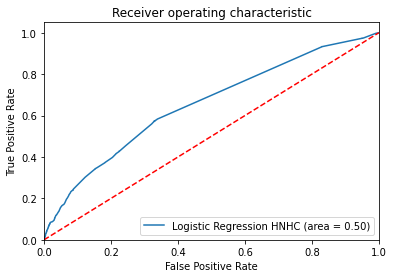

In [35]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_ROC_20')
plt.show()

In [36]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.24036741, 0.21303105, 0.19541883, 0.21968627, 0.21249747,
       0.221843  , 0.22505927, 0.20096064, 0.22705054, 0.22122765]), 'score_time': array([0.00996423, 0.00867534, 0.00794721, 0.00722456, 0.00794435,
       0.00899553, 0.00897789, 0.0075345 , 0.00878382, 0.01096916]), 'test_roc_auc': array([0.64261468, 0.6226554 , 0.64226094, 0.64136359, 0.60854523,
       0.64400196, 0.62437984, 0.64261551, 0.66167076, 0.65585527]), 'train_roc_auc': array([0.63961436, 0.64161119, 0.63943075, 0.63934651, 0.64339589,
       0.63884286, 0.64170264, 0.63915669, 0.63835617, 0.6383247 ]), 'test_precision': array([0.66666667, 0.5       , 0.        , 0.75      , 0.33333333,
       0.        , 0.66666667, 1.        , 0.5       , 0.        ]), 'train_precision': array([0.4375    , 0.52777778, 0.51515152, 0.4516129 , 0.44736842,
       0.6       , 0.47222222, 0.41025641, 0.44117647, 0.5       ]), 'test_recall': array([0.00849257, 0.00424628, 0.        , 0.00635593, 0.00211864,
     

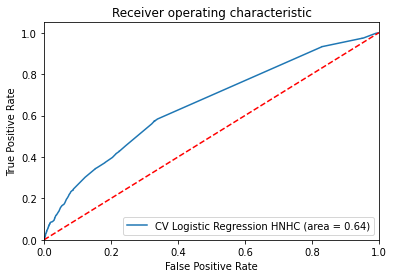

In [37]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_ROC_20')
plt.show()

In [38]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-0.8284532606207784, 'new_unstableangina_adm'),
 (-0.8084695025607813, 'pq2_perf_appendix'),
 (-0.6389135565701941, 'neuro_adm'),
 (-0.5517191765795582, 'elective'),
 (-0.43734849391249814, 'new_meningitis_adm'),
 (0.3868452936097696, 'new_endocarditis_adm'),
 (0.4476730870070863, 'cm_dmcx'),
 (0.466598353136373, 'orproc'),
 (0.479985861917099, 'cm_psych'),
 (0.5075200895886512, 'chronic_pain'),
 (0.5487916943943579, 'cm_mets'),
 (0.5655689519829887, 'cm_drug'),
 (0.5696644914666433, 'new_septicemia_adm'),
 (0.6385494273588112, 'thromboses'),
 (0.6557951249036615, 'cm_renlfail'),
 (0.7996383238383921, 'new_osteo_adm'),
 (0.8040823314375701, 'cm_lymph'),
 (0.8324130004621763, 'new_atypicalmyco_adm'),
 (0.8751522835550768, 'cm_para'),
 (1.0605317428004983, 'cm_ulcer')]

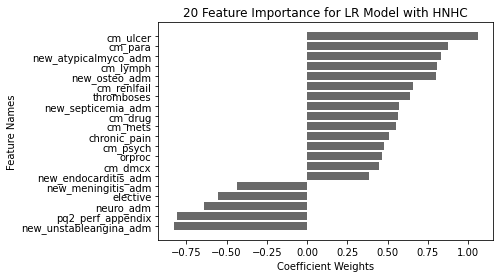

In [39]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for LR Model with HNHC')
plt.savefig('images\Logistic_Regression_HNHC_Feature_Importance_20')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="lrhnhcnolos"></a> 

[Return to Table of Contents](#contents)

In [40]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['severe_IBD_hospitalization' 'cm_dmcx' 'cm_drug' 'cm_liver' 'cm_lymph'
 'cm_para' 'cm_psych' 'cm_renlfail' 'cm_ulcer' 'cm_wghtloss'
 'blood_transfusion' 'thromboses' 'pq1_dm_short' 'pq2_perf_appendix'
 'pq8_chf' 'new_unstableangina_adm' 'new_meningitis_adm'
 'new_atypicalmyco_adm' 'chronic_pain' 'neuro_adm']


In [41]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

hnhc_patients  severe_IBD_hospitalization  cm_dmcx  cm_drug  cm_liver  \
0                  0                           0        0        0         0   
3                  0                           0        0        0         0   
4                  1                           0        0        0         0   
9                  0                           0        0        0         0   
10                 0                           0        0        0         0   
...              ...                         ...      ...      ...       ...   
94491              0                           0        0        0         0   
94492              0                           0        0        0         0   
94493              1                           1        0        0         0   
94496              0                           0        0        0         0   
94497              0                           0        0        0         0   

       cm_lymph  cm_para  cm_psych  cm_renlfail  cm_ulcer  cm_wghtloss  \
0             0        0         0            0         0            0   
3             0        0         0            0         0            0   
4             0        0         0            0         0            0   
9             0        0         0            0         0            0   
10            0        0         0            0         0            0   
...         ...      ...       ...          ...       ...          ...   
94491         0        0         0            0         0            0   
94492         0        0         0            0         0            0   
94493         0        0         0            0         0            0   
94496         0        0         0            0         0            0   
94497         0        0         0            0         0            0   

       blood_transfusion  thromboses  pq1_dm_short  pq2_perf_appendix  \
0                      0           0             0                  0   
3                      0           0             0                  0   
4                      0           0             0                  0   
9                      0           0             0                  0   
10                     0           0             0                  0   
...                  ...         ...           ...                ...   
94491                  0           0             0                  0   
94492                  0           0             0                  0   
94493                  1           0             0                  0   
94496                  0           0             0                  0   
94497                  0           0             0                  0   

       pq8_chf  new_unstableangina_adm  new_meningitis_adm  \
0            0                       0                   0   
3            0                       0                   0   
4            0                       0                   0   
9            0                       0                   0   
10           0                       0                   0   
...        ...                     ...                 ...   
94491        0                       0                   0   
94492        0                       0                   0   
94493        0                       0                   0   
94496        0                       0                   0   
94497        0                       0                   0   

       new_atypicalmyco_adm  chronic_pain  neuro_adm  
0                         0             0          0  
3                         0             0          0  
4                         0             0          0  
9                         0             0          0  
10                        0             0          0  
...                     ...           ...        ...  
94491                     0             0          0  
94492                     0             0          0  
94493                     0             

In [42]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47402, dtype: int64

In [43]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['severe_IBD_hospitalization', 'cm_dmcx', 'cm_drug', 'cm_liver',
       'cm_lymph', 'cm_para', 'cm_psych', 'cm_renlfail', 'cm_ulcer',
       'cm_wghtloss', 'blood_transfusion', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq8_chf', 'new_unstableangina_adm',
       'new_meningitis_adm', 'new_atypicalmyco_adm', 'chronic_pain',
       'neuro_adm'],
      dtype='object')

In [44]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.899946555652443
Testing Score: 0.9020335836638258


In [45]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

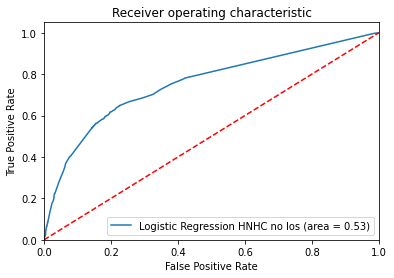

In [46]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_no_los_ROC_20')
plt.show()

In [47]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.2523222 , 0.26273417, 0.17567992, 0.25937772, 0.27151132,
       0.23446155, 0.25143957, 0.20676351, 0.23321366, 0.22194624]), 'score_time': array([0.00897574, 0.00792027, 0.00801182, 0.00800514, 0.00846553,
       0.0079968 , 0.0080111 , 0.00797582, 0.00782323, 0.00777078]), 'test_roc_auc': array([0.7542564 , 0.73181063, 0.74738486, 0.7729797 , 0.75173012,
       0.76689356, 0.76036388, 0.75345819, 0.75120402, 0.76964536]), 'train_roc_auc': array([0.75709831, 0.75937266, 0.7578004 , 0.75474576, 0.75731463,
       0.75563425, 0.75661198, 0.75710276, 0.75735812, 0.75551572]), 'test_precision': array([0.51923077, 0.40540541, 0.57894737, 0.48387097, 0.45762712,
       0.47368421, 0.5       , 0.59016393, 0.53623188, 0.43478261]), 'train_precision': array([0.48789572, 0.50346021, 0.49034749, 0.51190476, 0.50089767,
       0.52323232, 0.50300601, 0.50695825, 0.49816176, 0.495671  ]), 'test_recall': array([0.05720339, 0.06355932, 0.07006369, 0.06369427, 0.05732484,
     

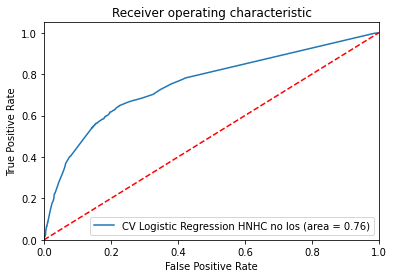

In [48]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_HNHC_no_los_ROC_20')
plt.show()

In [49]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.2254085598137363, 'pq2_perf_appendix'),
 (-0.7480189756257094, 'new_unstableangina_adm'),
 (-0.6728404949542365, 'new_meningitis_adm'),
 (-0.538987801520643, 'neuro_adm'),
 (0.018170254561245304, 'pq8_chf'),
 (0.3781229120081849, 'cm_liver'),
 (0.43977829188134143, 'cm_psych'),
 (0.44187085949158394, 'cm_renlfail'),
 (0.451630759875075, 'cm_drug'),
 (0.4647590636347451, 'cm_para'),
 (0.47190857659014895, 'thromboses'),
 (0.47587770795444123, 'blood_transfusion'),
 (0.4875191635770292, 'cm_wghtloss'),
 (0.5134190833197821, 'chronic_pain'),
 (0.5199449730208715, 'cm_dmcx'),
 (0.6368687389933797, 'cm_ulcer'),
 (0.6726336225505793, 'cm_lymph'),
 (0.6920965294872675, 'new_atypicalmyco_adm'),
 (1.0576443161045934, 'pq1_dm_short'),
 (1.7626965510251689, 'severe_IBD_hospitalization')]

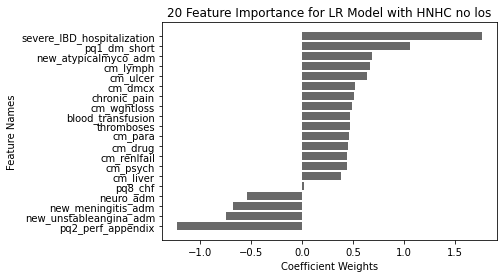

In [50]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for LR Model with HNHC no los')
plt.savefig('images\Logistic_Regression_HNHC_no_los_Feature_Importance_20')
plt.show()

## Target: IBD_READM <a class="anchor" id="lrreadm"></a>

[Return to Table of Contents](#contents)

In [51]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['abd_pain_adm' 'severe_IBD_hospitalization' 'cm_dmcx' 'cm_drug'
 'cm_lymph' 'pq2_perf_appendix' 'pq7_htn' 'pq10_dehydrate'
 'pq11_bacterialpna' 'pq16_dm_amputate' 'new_cardiacarrest_adm'
 'new_meningitis_adm' 'new_encephalitis_adm' 'new_osteo_adm' 'new_tb_adm'
 'new_atypicalmyco_adm' 'new_fungal_adm' 'new_listeriosis_adm'
 'chronic_pain' 'prevent_readm']


In [52]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

ibd_readm  abd_pain_adm  severe_IBD_hospitalization  cm_dmcx  cm_drug  \
0             1             0                           0        0        0   
3             0             0                           0        0        0   
4             1             0                           0        0        0   
9             0             0                           0        0        0   
10            0             0                           0        0        0   
...         ...           ...                         ...      ...      ...   
94491         0             0                           0        0        0   
94492         0             0                           0        0        0   
94493         1             0                           1        0        0   
94496         0             0                           0        0        0   
94497         0             0                           0        0        0   

       cm_lymph  pq2_perf_appendix  pq7_htn  pq10_dehydrate  \
0             0                  0        0               0   
3             0                  0        0               0   
4             0                  0        0               0   
9             0                  0        0               0   
10            0                  0        0               0   
...         ...                ...      ...             ...   
94491         0                  0        0               0   
94492         0                  0        0               0   
94493         0                  0        0               0   
94496         0                  0        0               0   
94497         0                  0        0               0   

       pq11_bacterialpna  pq16_dm_amputate  new_cardiacarrest_adm  \
0                      0                 0                      0   
3                      0                 0                      0   
4                      0                 0                      0   
9                      0                 0                      0   
10                     0                 0                      0   
...                  ...               ...                    ...   
94491                  0                 0                      0   
94492                  0                 0                      0   
94493                  0                 0                      0   
94496                  0                 0                      0   
94497                  0                 0                      0   

       new_meningitis_adm  new_encephalitis_adm  new_osteo_adm  new_tb_adm  \
0                       0                     0              0           0   
3                       0                     0              0           0   
4                       0                     0              0           0   
9                       0                     0              0           0   
10                      0                     0              0           0   
...                   ...                   ...            ...         ...   
94491                   0                     0              0           0   
94492                   0                     0              0           0   
94493                   0                     0              0           0   
94496                   0                     0              0           0   
94497                   0                     0              0           0   

       new_atypicalmyco_adm  new_fungal_adm  new_listeriosis_adm  \
0                         0               0                    0   
3                         0               0                    0   
4                         0               0                    0   
9                         0               0                    0   
10                        0               0                    0   
...                     ...             ...                  ...   
94491                     0               0               

In [53]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [54]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['abd_pain_adm', 'severe_IBD_hospitalization', 'cm_dmcx', 'cm_drug',
       'cm_lymph', 'pq2_perf_appendix', 'pq7_htn', 'pq10_dehydrate',
       'pq11_bacterialpna', 'pq16_dm_amputate', 'new_cardiacarrest_adm',
       'new_meningitis_adm', 'new_encephalitis_adm', 'new_osteo_adm',
       'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm',
       'new_listeriosis_adm', 'chronic_pain', 'prevent_readm'],
      dtype='object')

In [55]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.5928947146353126
Testing Score: 0.6017213737237364


In [56]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

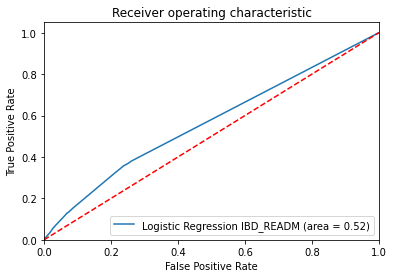

In [57]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_ROC_20')
plt.show()

In [58]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.22872734, 0.2388711 , 0.23156166, 0.2103982 , 0.21764612,
       0.23672509, 0.20940495, 0.16884923, 0.2070055 , 0.21135497]), 'score_time': array([0.00997519, 0.00801086, 0.00869799, 0.00876617, 0.00964522,
       0.00898814, 0.00898099, 0.00803185, 0.00806212, 0.008286  ]), 'test_roc_auc': array([0.55965986, 0.56446905, 0.55003411, 0.56140829, 0.5568482 ,
       0.56084082, 0.56691015, 0.56494792, 0.55263808, 0.56556998]), 'train_roc_auc': array([0.56141966, 0.56085248, 0.5624033 , 0.56123678, 0.5616337 ,
       0.56123742, 0.56058568, 0.56091685, 0.56218311, 0.56076002]), 'test_precision': array([0.53804348, 0.65909091, 0.53252033, 0.56589147, 0.51826484,
       0.5415677 , 0.57086614, 0.62295082, 0.57613169, 0.58933333]), 'train_precision': array([0.56602163, 0.58187528, 0.5835443 , 0.58885017, 0.56100868,
       0.56001106, 0.58987001, 0.58292791, 0.58893281, 0.5615693 ]), 'test_recall': array([0.10086602, 0.08863984, 0.06673459, 0.07437596, 0.11569827,
     

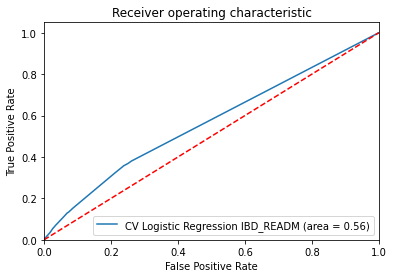

In [59]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_ROC_20')
plt.show()

In [60]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.8031632417553194, 'new_cardiacarrest_adm'),
 (-1.296102951436296, 'pq2_perf_appendix'),
 (-1.0571291487197, 'new_meningitis_adm'),
 (-0.6607544841997728, 'new_listeriosis_adm'),
 (-0.5874416071054598, 'pq7_htn'),
 (-0.48670107039133437, 'new_tb_adm'),
 (-0.42524400587796823, 'pq11_bacterialpna'),
 (-0.41282721644997816, 'pq10_dehydrate'),
 (0.39085422446647605, 'pq16_dm_amputate'),
 (0.3968978035099028, 'cm_lymph'),
 (0.39925780531274474, 'cm_drug'),
 (0.41647901889623906, 'severe_IBD_hospitalization'),
 (0.4229419071576953, 'new_fungal_adm'),
 (0.4406278164600102, 'abd_pain_adm'),
 (0.4515468885207194, 'new_osteo_adm'),
 (0.46431056319640823, 'cm_dmcx'),
 (0.46534710997689244, 'prevent_readm'),
 (0.6197249389326455, 'chronic_pain'),
 (0.6506723605182481, 'new_encephalitis_adm'),
 (0.8009562194183758, 'new_atypicalmyco_adm')]

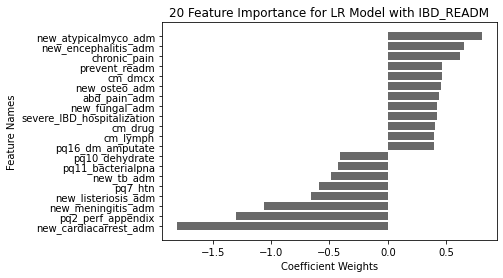

In [61]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for LR Model with IBD_READM')
plt.savefig('images\Logistic_Regression_IBD_READM_Feature_Importance_20')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="lrreadmnolos"></a>

[Return to Table of Contents](#contents)

In [62]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

clf_log = LogisticRegression(random_state=42)
trans_log = RFE(clf_log, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

['abd_pain_adm' 'severe_IBD_hospitalization' 'cm_dmcx' 'cm_drug'
 'cm_lymph' 'pq2_perf_appendix' 'pq7_htn' 'pq10_dehydrate'
 'pq11_bacterialpna' 'pq13_angina' 'pq16_dm_amputate'
 'new_cardiacarrest_adm' 'new_meningitis_adm' 'new_encephalitis_adm'
 'new_tb_adm' 'new_atypicalmyco_adm' 'new_fungal_adm'
 'new_listeriosis_adm' 'chronic_pain' 'prevent_readm']


In [63]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

ibd_readm  abd_pain_adm  severe_IBD_hospitalization  cm_dmcx  cm_drug  \
0             1             0                           0        0        0   
3             0             0                           0        0        0   
4             1             0                           0        0        0   
9             0             0                           0        0        0   
10            0             0                           0        0        0   
...         ...           ...                         ...      ...      ...   
94491         0             0                           0        0        0   
94492         0             0                           0        0        0   
94493         1             0                           1        0        0   
94496         0             0                           0        0        0   
94497         0             0                           0        0        0   

       cm_lymph  pq2_perf_appendix  pq7_htn  pq10_dehydrate  \
0             0                  0        0               0   
3             0                  0        0               0   
4             0                  0        0               0   
9             0                  0        0               0   
10            0                  0        0               0   
...         ...                ...      ...             ...   
94491         0                  0        0               0   
94492         0                  0        0               0   
94493         0                  0        0               0   
94496         0                  0        0               0   
94497         0                  0        0               0   

       pq11_bacterialpna  pq13_angina  pq16_dm_amputate  \
0                      0            0                 0   
3                      0            0                 0   
4                      0            0                 0   
9                      0            0                 0   
10                     0            0                 0   
...                  ...          ...               ...   
94491                  0            0                 0   
94492                  0            0                 0   
94493                  0            0                 0   
94496                  0            0                 0   
94497                  0            0                 0   

       new_cardiacarrest_adm  new_meningitis_adm  new_encephalitis_adm  \
0                          0                   0                     0   
3                          0                   0                     0   
4                          0                   0                     0   
9                          0                   0                     0   
10                         0                   0                     0   
...                      ...                 ...                   ...   
94491                      0                   0                     0   
94492                      0                   0                     0   
94493                      0                   0                     0   
94496                      0                   0                     0   
94497                      0                   0                     0   

       new_tb_adm  new_atypicalmyco_adm  new_fungal_adm  new_listeriosis_adm  \
0               0                     0               0                    0   
3               0                     0               0                    0   
4               0                     0               0                    0   
9               0                     0               0                    0   
10              0                     0               0                    0   
...           ...                   ...             ...                  ...   
94491           0                     0               0                    0   
94492           0                     0               0       

In [64]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47402, dtype: int64

In [65]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['abd_pain_adm', 'severe_IBD_hospitalization', 'cm_dmcx', 'cm_drug',
       'cm_lymph', 'pq2_perf_appendix', 'pq7_htn', 'pq10_dehydrate',
       'pq11_bacterialpna', 'pq13_angina', 'pq16_dm_amputate',
       'new_cardiacarrest_adm', 'new_meningitis_adm', 'new_encephalitis_adm',
       'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm',
       'new_listeriosis_adm', 'chronic_pain', 'prevent_readm'],
      dtype='object')

In [66]:
# Initial model with LogisticRegression

from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

logistic_reg = LogisticRegression(random_state=42)

logistic_reg.fit(X_train_log, y_train_log)

print(f'Training Score: {logistic_reg.score(X_train_log, y_train_log)}')
print(f'Testing Score: {logistic_reg.score(X_test_log, y_test_log)}')

Training Score: 0.5926696858034936
Testing Score: 0.6015526115939583


In [67]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, logistic_reg.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, logistic_reg.predict_proba(X_test_log)[:,1])

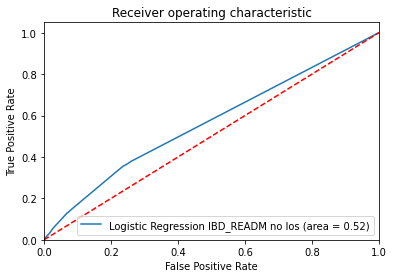

In [68]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='Logistic Regression IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_ROC_20')
plt.show()

In [69]:
# K-Fold Validation using Logistic Regression
clf_log_rf = LogisticRegression()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.19245291, 0.24794841, 0.19208026, 0.18938589, 0.18065882,
       0.1920197 , 0.22437859, 0.19121361, 0.16703176, 0.18708396]), 'score_time': array([0.00897598, 0.00821996, 0.00910378, 0.00801277, 0.00900698,
       0.00801182, 0.00866389, 0.00848746, 0.00901389, 0.00839019]), 'test_roc_auc': array([0.55934106, 0.56359204, 0.54979141, 0.56177151, 0.55819534,
       0.55996273, 0.56647147, 0.56527083, 0.55202208, 0.56481151]), 'train_roc_auc': array([0.5611405 , 0.56076639, 0.56211451, 0.56095712, 0.56123895,
       0.56112365, 0.56031392, 0.56055099, 0.56197537, 0.56052441]), 'test_precision': array([0.53719008, 0.60714286, 0.53727506, 0.57613169, 0.52870813,
       0.54126214, 0.56048387, 0.6255144 , 0.56509695, 0.59289617]), 'train_precision': array([0.56719884, 0.56135238, 0.5624653 , 0.58982585, 0.56270997,
       0.56096874, 0.59065934, 0.58216388, 0.56450688, 0.56242707]), 'test_recall': array([0.09933775, 0.121243  , 0.10646969, 0.07131941, 0.11264016,
     

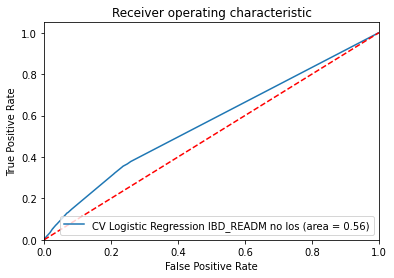

In [70]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV Logistic Regression IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Logistic_Regression_IBD_READM_no_los_ROC_20')
plt.show()

In [71]:
# Check the feature importance using the LogisticRegression model
for value in logistic_reg.coef_:
    log_reg_importance = sorted(zip(value, X_train_log))
log_reg_importance

[(-1.8018855674608718, 'new_cardiacarrest_adm'),
 (-1.308032149708811, 'pq2_perf_appendix'),
 (-1.0494445424045862, 'new_meningitis_adm'),
 (-0.6628012377743161, 'new_listeriosis_adm'),
 (-0.5980620777481213, 'pq7_htn'),
 (-0.5010382186371026, 'new_tb_adm'),
 (-0.4420151374171518, 'pq13_angina'),
 (-0.43296097483152407, 'pq11_bacterialpna'),
 (-0.4209022760222133, 'pq10_dehydrate'),
 (0.37727221282267, 'pq16_dm_amputate'),
 (0.3973518404478078, 'cm_lymph'),
 (0.4003165945520742, 'cm_drug'),
 (0.41483316952125915, 'new_fungal_adm'),
 (0.4182861688404476, 'severe_IBD_hospitalization'),
 (0.4408279393236315, 'abd_pain_adm'),
 (0.4676224076224276, 'cm_dmcx'),
 (0.47248579014655123, 'prevent_readm'),
 (0.6204758787221116, 'chronic_pain'),
 (0.6482364659670282, 'new_encephalitis_adm'),
 (0.8175798094094576, 'new_atypicalmyco_adm')]

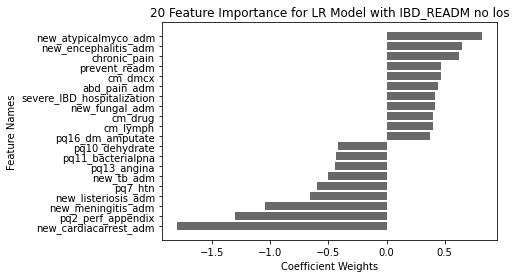

In [72]:
# Graph feature importance for Logistic Regression
plt.barh([y[1] for y in log_reg_importance], [x[0] for x in log_reg_importance], color='dimgray')
plt.xlabel('Coefficient Weights')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for LR Model with IBD_READM no los')
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_Feature_Importance_20')
plt.show()

## Decision Tree Classifier RFE <a class="anchor" id="decisiontreerfe"></a> 

## Target: HNHC <a class="anchor" id="dthnhc"></a>

[Return to Table of Contents](#contents)

In [73]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=20)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'los' 'aweekend' 'payer' 'zipinc_qrtl' 'cm_anemdef'
 'cm_chrnlung' 'cm_htn_c' 'cm_lytes' 'cm_smoking' 'ibd_procedures'
 'cc_index' 'frailty_risk_score' 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach'
 'hosp_urcat4' 'gi_adm' 'ibd_specific_adm']


In [74]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

hnhc_patients  age  female  los  aweekend  payer  zipinc_qrtl  \
0                  0   89       0    4         1    1.0          4.0   
3                  0   48       1    4         0    2.0          3.0   
4                  1   65       0    5         0    1.0          2.0   
9                  0   51       0    3         0    2.0          4.0   
10                 0   22       0    6         0    1.0          2.0   
...              ...  ...     ...  ...       ...    ...          ...   
94491              0   32       1    3         1    2.0          4.0   
94492              0   54       0    4         0    2.0          4.0   
94493              1   44       0    9         0    2.0          4.0   
94496              0   52       1    2         0    1.0          1.0   
94497              0   72       0    4         1    1.0          2.0   

       cm_anemdef  cm_chrnlung  cm_htn_c  cm_lytes  cm_smoking  \
0               1            1         1         1           1   
3               0            0         0         0           1   
4               1            0         1         1           1   
9               0            0         0         1           1   
10              0            0         0         1           0   
...           ...          ...       ...       ...         ...   
94491           0            0         0         0           0   
94492           0            0         0         0           0   
94493           0            0         0         0           0   
94496           0            1         1         0           0   
94497           0            0         1         0           1   

       ibd_procedures  cc_index  frailty_risk_score  h_contrl  hosp_bedsize  \
0                   0         2                 4.7         1             3   
3                   1         0                 0.5         1             3   
4                   0         0                 5.7         2             2   
9                   0         0                 2.8         2             2   
10                  1         0                 3.8         2             3   
...               ...       ...                 ...       ...           ...   
94491               0         0                 0.0         2             2   
94492               1         0                 0.0         2             3   
94493               1         0                 0.0         2             3   
94496               0         2                 1.5         2             3   
94497               0         1                 4.7         2             3   

       hosp_ur_teach  hosp_urcat4  gi_adm  ibd_specific_adm  
0                  1            1       0                 0  
3                  1            2       0                 1  
4                  1            2       0                 1  
9                  1            2       1                 0  
10                 1            2       1                 0  
...              ...          ...     ...               ...  
94491              1            1       0                 0  
94492              1            1       1                 0  
94493              1            1       0                 1  
94496              0            2       0                 0  
94497              0            2       0                 1  

[46632 rows x 21 columns]

In [75]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46632, dtype: int64

In [76]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'los', 'aweekend', 'payer', 'zipinc_qrtl',
       'cm_anemdef', 'cm_chrnlung', 'cm_htn_c', 'cm_lytes', 'cm_smoking',
       'ibd_procedures', 'cc_index', 'frailty_risk_score', 'h_contrl',
       'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'gi_adm',
       'ibd_specific_adm'],
      dtype='object')

In [77]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.8520329387545034


In [78]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

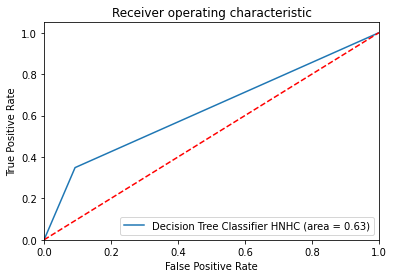

In [79]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_ROC_20')
plt.show()

In [80]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.07279682, 0.06881356, 0.07282376, 0.06083679, 0.06084323,
       0.06080461, 0.06485653, 0.06233525, 0.06084204, 0.05884051]), 'score_time': array([0.00897574, 0.0079782 , 0.00799227, 0.0079782 , 0.00797677,
       0.00900459, 0.00797868, 0.00717044, 0.00797868, 0.00794983]), 'test_roc_auc': array([0.78864169, 0.76875856, 0.76449108, 0.81026348, 0.77674487,
       0.79488086, 0.79265152, 0.774669  , 0.78979113, 0.78956607]), 'train_roc_auc': array([0.7912527 , 0.79468823, 0.78877827, 0.78900337, 0.7937866 ,
       0.79042562, 0.79098316, 0.78708014, 0.79070079, 0.78961288]), 'test_precision': array([0.80508475, 0.76635514, 0.76510067, 0.84615385, 0.77868852,
       0.77852349, 0.75483871, 0.80821918, 0.74556213, 0.75675676]), 'train_precision': array([0.82402707, 0.84269663, 0.79099924, 0.84446478, 0.82866836,
       0.79294479, 0.77144917, 0.77615216, 0.78342046, 0.81752412]), 'test_recall': array([0.20430108, 0.17634409, 0.24568966, 0.23706897, 0.20474138,
     

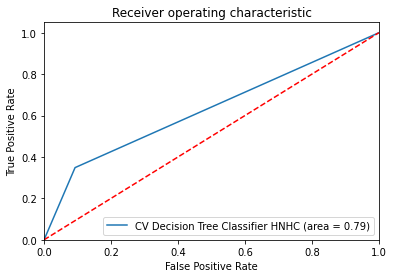

In [81]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_ROC_20')
plt.show()

In [82]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.015425340382704877, 'ibd_procedures'),
 (0.015439572107594932, 'cm_anemdef'),
 (0.016007948873664305, 'ibd_specific_adm'),
 (0.016238267172349732, 'cm_lytes'),
 (0.017783747981926924, 'cm_chrnlung'),
 (0.017937742481262103, 'gi_adm'),
 (0.021471107760663258, 'aweekend'),
 (0.021719748127605278, 'cm_smoking'),
 (0.022445171812826837, 'cm_htn_c'),
 (0.023080920116817737, 'payer'),
 (0.02368269833840264, 'female'),
 (0.024511094913037615, 'hosp_ur_teach'),
 (0.025991943899782332, 'hosp_urcat4'),
 (0.02981226119113682, 'hosp_bedsize'),
 (0.03210642125577008, 'h_contrl'),
 (0.04043345439255466, 'cc_index'),
 (0.05378472575693196, 'zipinc_qrtl'),
 (0.15379633540671098, 'age'),
 (0.15666188093275796, 'frailty_risk_score'),
 (0.271669617095499, 'los')]

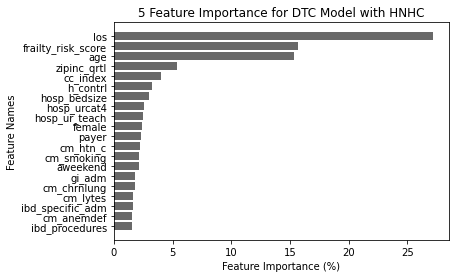

In [83]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('5 Feature Importance for DTC Model with HNHC')
plt.savefig('images\Decision_Tree_Classifier_HNHC_Feature_Importance_20')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="dthnhcnolos"></a>

[Return to Table of Contents](#contents)

In [84]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=20)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_5 = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'aweekend' 'payer' 'zipinc_qrtl'
 'severe_IBD_hospitalization' 'cm_chrnlung' 'cm_depress' 'cm_dm'
 'cm_htn_c' 'cm_lytes' 'cm_smoking' 'ibd_procedures' 'cc_index'
 'frailty_risk_score' 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach'
 'hosp_urcat4' 'ibd_specific_adm']


In [85]:
# Feature list from RFE results
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

hnhc_patients  age  female  aweekend  payer  zipinc_qrtl  \
0                  0   89       0         1    1.0          4.0   
3                  0   48       1         0    2.0          3.0   
4                  1   65       0         0    1.0          2.0   
9                  0   51       0         0    2.0          4.0   
10                 0   22       0         0    1.0          2.0   
...              ...  ...     ...       ...    ...          ...   
94491              0   32       1         1    2.0          4.0   
94492              0   54       0         0    2.0          4.0   
94493              1   44       0         0    2.0          4.0   
94496              0   52       1         0    1.0          1.0   
94497              0   72       0         1    1.0          2.0   

       severe_IBD_hospitalization  cm_chrnlung  cm_depress  cm_dm  cm_htn_c  \
0                               0            1           0      0         1   
3                               0            0           0      0         0   
4                               0            0           0      0         1   
9                               0            0           0      0         0   
10                              0            0           0      0         0   
...                           ...          ...         ...    ...       ...   
94491                           0            0           0      0         0   
94492                           0            0           0      0         0   
94493                           1            0           0      0         0   
94496                           0            1           1      1         1   
94497                           0            0           0      0         1   

       cm_lytes  cm_smoking  ibd_procedures  cc_index  frailty_risk_score  \
0             1           1               0         2                 4.7   
3             0           1               1         0                 0.5   
4             1           1               0         0                 5.7   
9             1           1               0         0                 2.8   
10            1           0               1         0                 3.8   
...         ...         ...             ...       ...                 ...   
94491         0           0               0         0                 0.0   
94492         0           0               1         0                 0.0   
94493         0           0               1         0                 0.0   
94496         0           0               0         2                 1.5   
94497         0           1               0         1                 4.7   

       h_contrl  hosp_bedsize  hosp_ur_teach  hosp_urcat4  ibd_specific_adm  
0             1             3              1            1                 0  
3             1             3              1            2                 1  
4             2             2              1            2                 1  
9             2             2              1            2                 0  
10            2             3              1            2                 0  
...         ...           ...            ...          ...               ...  
94491         2             2              1            1                 0  
94492         2             3              1            1                 0  
94493         2             3              1            1                 1  
94496         2             3              0            2                 0  
94497         2             3              0            2                 1  

[46632 rows x 21 columns]

In [86]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["hnhc_patients"]
target_names_selected = ["none", "hnhc"]
target_selected = target_selected.astype('int64')
target_selected

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46632, dtype: int64

In [87]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('hnhc_patients', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'aweekend', 'payer', 'zipinc_qrtl',
       'severe_IBD_hospitalization', 'cm_chrnlung', 'cm_depress', 'cm_dm',
       'cm_htn_c', 'cm_lytes', 'cm_smoking', 'ibd_procedures', 'cc_index',
       'frailty_risk_score', 'h_contrl', 'hosp_bedsize', 'hosp_ur_teach',
       'hosp_urcat4', 'ibd_specific_adm'],
      dtype='object')

In [88]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9997140733116029
Testing Score: 0.8333333333333334


In [89]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

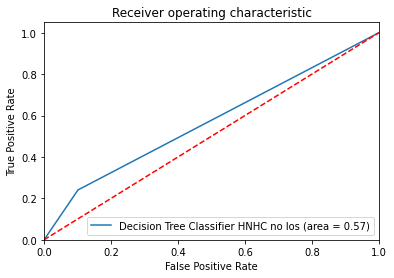

In [90]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_ROC_20')
plt.show()

In [91]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.06382942, 0.06881618, 0.08777046, 0.05484772, 0.05784512,
       0.05684781, 0.05684972, 0.05684662, 0.05585051, 0.0607996 ]), 'score_time': array([0.00898004, 0.00900412, 0.00897121, 0.00797939, 0.00697899,
       0.00801229, 0.00794411, 0.00794888, 0.00894451, 0.00801229]), 'test_roc_auc': array([0.76448617, 0.73063069, 0.76025311, 0.77194103, 0.75517955,
       0.77110468, 0.77429381, 0.7644685 , 0.76268159, 0.77292315]), 'train_roc_auc': array([0.774509  , 0.77789972, 0.77504216, 0.7739798 , 0.77500764,
       0.77285938, 0.7724891 , 0.77429409, 0.7743771 , 0.77333092]), 'test_precision': array([0.375     , 0.32432432, 0.55172414, 0.52777778, 0.62962963,
       0.37142857, 0.56521739, 0.57377049, 0.53246753, 0.66666667]), 'train_precision': array([0.60627178, 0.55716586, 0.554     , 0.53819444, 0.54582485,
       0.59235669, 0.58543417, 0.5418251 , 0.53236246, 0.57142857]), 'test_recall': array([0.02580645, 0.0516129 , 0.06896552, 0.08189655, 0.07327586,
     

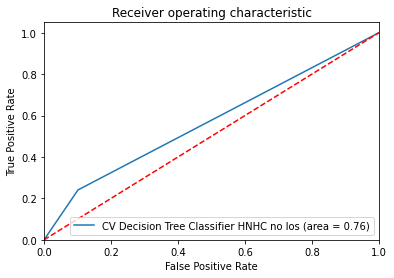

In [92]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_no_los_ROC_20')
plt.show()

In [93]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.01817338588451427, 'cm_chrnlung'),
 (0.018323240254741358, 'cm_dm'),
 (0.021382512496810797, 'payer'),
 (0.02146553835386669, 'ibd_procedures'),
 (0.022600096771612854, 'ibd_specific_adm'),
 (0.023030974536181, 'cm_lytes'),
 (0.02349742520248189, 'cm_htn_c'),
 (0.024892195012073768, 'cm_depress'),
 (0.02611572767640226, 'cm_smoking'),
 (0.027043757812646643, 'hosp_urcat4'),
 (0.027325741412467453, 'aweekend'),
 (0.02763042288788038, 'female'),
 (0.032367625081703634, 'hosp_ur_teach'),
 (0.034023423936992286, 'hosp_bedsize'),
 (0.04289290598327424, 'h_contrl'),
 (0.04691891488897985, 'cc_index'),
 (0.06196987864564111, 'zipinc_qrtl'),
 (0.09973949148028913, 'severe_IBD_hospitalization'),
 (0.19148978022516552, 'age'),
 (0.20911696145627498, 'frailty_risk_score')]

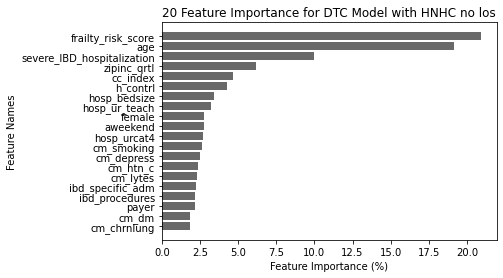

In [94]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for DTC Model with HNHC no los')
plt.savefig('images\Decision_Tree_Classifier_HNHC_no_los_Feature_Importance_20')
plt.show()

## Target: IBD_READM <a class="anchor" id="dtreadm"></a>

[Return to Table of Contents](#contents)

In [95]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=20)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'los' 'aweekend' 'payer' 'zipinc_qrtl' 'cm_depress'
 'cm_dm' 'cm_htn_c' 'cm_hypothy' 'cm_lytes' 'cm_smoking' 'ibd_procedures'
 'cc_index' 'frailty_risk_score' 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach'
 'hosp_urcat4' 'gi_adm']


In [96]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

ibd_readm  age  female  los  aweekend  payer  zipinc_qrtl  cm_depress  \
0             1   89       0    4         1    1.0          4.0           0   
3             0   48       1    4         0    2.0          3.0           0   
4             1   65       0    5         0    1.0          2.0           0   
9             0   51       0    3         0    2.0          4.0           0   
10            0   22       0    6         0    1.0          2.0           0   
...         ...  ...     ...  ...       ...    ...          ...         ...   
94491         0   32       1    3         1    2.0          4.0           0   
94492         0   54       0    4         0    2.0          4.0           0   
94493         1   44       0    9         0    2.0          4.0           0   
94496         0   52       1    2         0    1.0          1.0           1   
94497         0   72       0    4         1    1.0          2.0           0   

       cm_dm  cm_htn_c  cm_hypothy  cm_lytes  cm_smoking  ibd_procedures  \
0          0         1           1         1           1               0   
3          0         0           0         0           1               1   
4          0         1           0         1           1               0   
9          0         0           0         1           1               0   
10         0         0           0         1           0               1   
...      ...       ...         ...       ...         ...             ...   
94491      0         0           0         0           0               0   
94492      0         0           0         0           0               1   
94493      0         0           0         0           0               1   
94496      1         1           1         0           0               0   
94497      0         1           0         0           1               0   

       cc_index  frailty_risk_score  h_contrl  hosp_bedsize  hosp_ur_teach  \
0             2                 4.7         1             3              1   
3             0                 0.5         1             3              1   
4             0                 5.7         2             2              1   
9             0                 2.8         2             2              1   
10            0                 3.8         2             3              1   
...         ...                 ...       ...           ...            ...   
94491         0                 0.0         2             2              1   
94492         0                 0.0         2             3              1   
94493         0                 0.0         2             3              1   
94496         2                 1.5         2             3              0   
94497         1                 4.7         2             3              0   

       hosp_urcat4  gi_adm  
0                1       0  
3                2       0  
4                2       0  
9                2       1  
10               2       1  
...            ...     ...  
94491            1       0  
94492            1       1  
94493            1       0  
94496            2       0  
94497            2       0  

[46632 rows x 21 columns]

In [97]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46632, dtype: int64

In [98]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'los', 'aweekend', 'payer', 'zipinc_qrtl',
       'cm_depress', 'cm_dm', 'cm_htn_c', 'cm_hypothy', 'cm_lytes',
       'cm_smoking', 'ibd_procedures', 'cc_index', 'frailty_risk_score',
       'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'gi_adm'],
      dtype='object')

In [99]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9992851832790073
Testing Score: 0.529336078229542


In [100]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

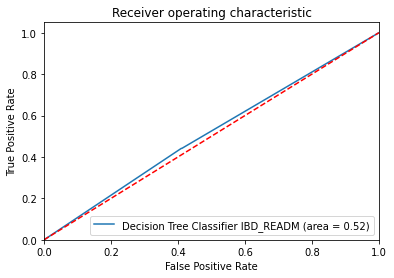

In [101]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_ROC_20')
plt.show()

In [102]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.06083727, 0.06382942, 0.05684829, 0.05784488, 0.06083655,
       0.05887485, 0.05983925, 0.06183863, 0.05885458, 0.06083608]), 'score_time': array([0.01200008, 0.01094007, 0.00797915, 0.00897646, 0.00797939,
       0.0089736 , 0.0089817 , 0.00996852, 0.00893235, 0.0079782 ]), 'test_roc_auc': array([0.604846  , 0.60603928, 0.61474736, 0.61702263, 0.60546815,
       0.61035942, 0.60520269, 0.61816467, 0.61984597, 0.60713741]), 'train_roc_auc': array([0.62022541, 0.62118023, 0.61939724, 0.62013862, 0.62022559,
       0.62027354, 0.62069803, 0.61919671, 0.61836955, 0.62102506]), 'test_precision': array([0.53047776, 0.53917051, 0.54385965, 0.54202077, 0.51732883,
       0.5565032 , 0.53608247, 0.57000993, 0.55123675, 0.5443459 ]), 'train_precision': array([0.54782197, 0.55335763, 0.54447824, 0.55448582, 0.54809715,
       0.55846344, 0.54581825, 0.55377243, 0.56296861, 0.56597898]), 'test_recall': array([0.33367876, 0.30310881, 0.32141006, 0.2975635 , 0.31726283,
     

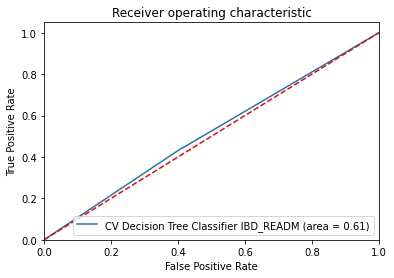

In [103]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_ROC_20')
plt.show()

In [104]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.015273074720744224, 'cm_dm'),
 (0.017257017400079462, 'cm_hypothy'),
 (0.018037360351762205, 'cm_lytes'),
 (0.020230033902265847, 'cm_depress'),
 (0.022984856181700018, 'cm_htn_c'),
 (0.023382660618979485, 'gi_adm'),
 (0.02351649658774884, 'cm_smoking'),
 (0.023859317262282166, 'ibd_procedures'),
 (0.025913263730947357, 'payer'),
 (0.02662686155231384, 'female'),
 (0.02733322494053625, 'aweekend'),
 (0.035727713383923006, 'cc_index'),
 (0.036482903008974193, 'hosp_ur_teach'),
 (0.03941330844513004, 'hosp_urcat4'),
 (0.04078931008863054, 'h_contrl'),
 (0.04288187643050684, 'hosp_bedsize'),
 (0.07126664699035726, 'zipinc_qrtl'),
 (0.1025438763528128, 'los'),
 (0.18907735118835384, 'frailty_risk_score'),
 (0.1974028468619518, 'age')]

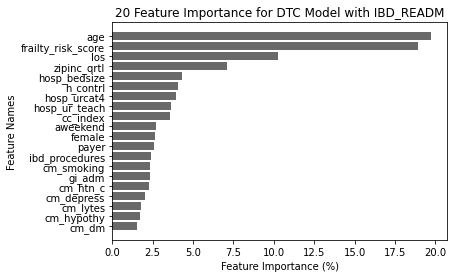

In [105]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for DTC Model with IBD_READM')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_Feature_Importance_20')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="dtreadmnolos"></a>

[Return to Table of Contents](#contents)

In [106]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(random_state=42)
trans = RFE(clf, n_features_to_select=20)
data_trans = trans.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_5 = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans.get_support()].values
print(columns_retained_RFE_5)

['age' 'female' 'aweekend' 'payer' 'zipinc_qrtl' 'cm_depress' 'cm_dm'
 'cm_htn_c' 'cm_hypothy' 'cm_lytes' 'cm_smoking' 'ibd_procedures'
 'cc_index' 'frailty_risk_score' 'h_contrl' 'hosp_bedsize' 'hosp_ur_teach'
 'hosp_urcat4' 'infxn_adm' 'gi_adm']


In [107]:
# Feature list from RFE results
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_5)
data_log = readm_data_df[features_list]

cleaned_data_selected = data_log.dropna(axis='rows')
cleaned_data_selected

ibd_readm  age  female  aweekend  payer  zipinc_qrtl  cm_depress  cm_dm  \
0             1   89       0         1    1.0          4.0           0      0   
3             0   48       1         0    2.0          3.0           0      0   
4             1   65       0         0    1.0          2.0           0      0   
9             0   51       0         0    2.0          4.0           0      0   
10            0   22       0         0    1.0          2.0           0      0   
...         ...  ...     ...       ...    ...          ...         ...    ...   
94491         0   32       1         1    2.0          4.0           0      0   
94492         0   54       0         0    2.0          4.0           0      0   
94493         1   44       0         0    2.0          4.0           0      0   
94496         0   52       1         0    1.0          1.0           1      1   
94497         0   72       0         1    1.0          2.0           0      0   

       cm_htn_c  cm_hypothy  cm_lytes  cm_smoking  ibd_procedures  cc_index  \
0             1           1         1           1               0         2   
3             0           0         0           1               1         0   
4             1           0         1           1               0         0   
9             0           0         1           1               0         0   
10            0           0         1           0               1         0   
...         ...         ...       ...         ...             ...       ...   
94491         0           0         0           0               0         0   
94492         0           0         0           0               1         0   
94493         0           0         0           0               1         0   
94496         1           1         0           0               0         2   
94497         1           0         0           1               0         1   

       frailty_risk_score  h_contrl  hosp_bedsize  hosp_ur_teach  hosp_urcat4  \
0                     4.7         1             3              1            1   
3                     0.5         1             3              1            2   
4                     5.7         2             2              1            2   
9                     2.8         2             2              1            2   
10                    3.8         2             3              1            2   
...                   ...       ...           ...            ...          ...   
94491                 0.0         2             2              1            1   
94492                 0.0         2             3              1            1   
94493                 0.0         2             3              1            1   
94496                 1.5         2             3              0            2   
94497                 4.7         2             3              0            2   

       infxn_adm  gi_adm  
0              1       0  
3              0       0  
4              0       0  
9              0       1  
10             0       1  
...          ...     ...  
94491          0       0  
94492          0       1  
94493          0       0  
94496          0       0  
94497          0       0  

[46632 rows x 21 columns]

In [108]:
# Grab outcome/label names after dropping na's/rows with na's
target_selected = cleaned_data_selected["ibd_readm"]
target_names_selected = ["none", "ibd_readm"]
target_selected = target_selected.astype('int64')
target_selected

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46632, dtype: int64

In [109]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_selected = cleaned_data_selected.drop('ibd_readm', axis=1)
featured_names_selected = cleaned_data_wo_outcome_selected.columns
featured_names_selected

Index(['age', 'female', 'aweekend', 'payer', 'zipinc_qrtl', 'cm_depress',
       'cm_dm', 'cm_htn_c', 'cm_hypothy', 'cm_lytes', 'cm_smoking',
       'ibd_procedures', 'cc_index', 'frailty_risk_score', 'h_contrl',
       'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'infxn_adm', 'gi_adm'],
      dtype='object')

In [110]:
# Fit with Decision Tree Classifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_selected, target_selected, random_state=42)

rf = DecisionTreeClassifier(random_state=42)

rf.fit(X_train, y_train)

print(f'Training Score: {rf.score(X_train, y_train)}')
print(f'Testing Score: {rf.score(X_test, y_test)}')

Training Score: 0.9968833990964716
Testing Score: 0.5337965345685366


In [111]:
# Creating ROC/AUC chart with model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_rf = roc_auc_score(y_test.values, rf.predict(X_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values, rf.predict_proba(X_test)[:,1])

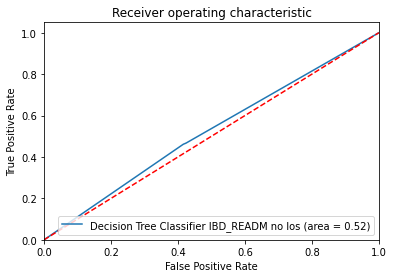

In [112]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Decision Tree Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_ROC_20')
plt.show()

In [113]:
# K-Fold Validation using Decision Tree Classifier
clf_log_rf = DecisionTreeClassifier(splitter = "best", max_depth = 5)

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_selected, target_selected, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

{'fit_time': array([0.06782007, 0.08876324, 0.05684829, 0.05784512, 0.05584979,
       0.05585051, 0.05784321, 0.06382942, 0.05983973, 0.06080699]), 'score_time': array([0.01296353, 0.0119698 , 0.00797892, 0.00797892, 0.0089767 ,
       0.00897455, 0.00797796, 0.00997543, 0.00897694, 0.00900531]), 'test_roc_auc': array([0.59075042, 0.58651684, 0.60928573, 0.60144294, 0.59346998,
       0.60407259, 0.59455182, 0.60057318, 0.60629003, 0.59567385]), 'train_roc_auc': array([0.60895523, 0.60921246, 0.6082195 , 0.60913474, 0.6097833 ,
       0.60851367, 0.60935949, 0.60814314, 0.60760696, 0.60973823]), 'test_precision': array([0.49466192, 0.53070866, 0.56313498, 0.52603707, 0.5256654 ,
       0.54625122, 0.5509434 , 0.54206731, 0.55827338, 0.53915663]), 'train_precision': array([0.55768484, 0.57276416, 0.5612764 , 0.54271758, 0.54560991,
       0.54665215, 0.58931624, 0.5558259 , 0.56690921, 0.54790807]), 'test_recall': array([0.21606218, 0.1746114 , 0.20114049, 0.30896838, 0.28667703,
     

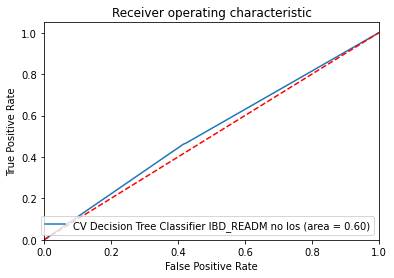

In [114]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='CV Decision Tree Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_no_los_ROC_20')
plt.show()

In [115]:
# Check the feature importance using the DecisionTreeClassifier model
dt_importance = sorted(zip(rf.feature_importances_, X_train))
dt_importance

[(0.01653530704990154, 'infxn_adm'),
 (0.017828377635424292, 'cm_lytes'),
 (0.01960074819978235, 'cm_dm'),
 (0.020988907737240027, 'cm_hypothy'),
 (0.021166231004763388, 'cm_depress'),
 (0.02495051415153757, 'ibd_procedures'),
 (0.025397455127050005, 'gi_adm'),
 (0.026533477645510308, 'cm_smoking'),
 (0.02692229306252189, 'aweekend'),
 (0.027046721092339347, 'female'),
 (0.028506094433749136, 'payer'),
 (0.03105580316493662, 'cm_htn_c'),
 (0.036498230275947306, 'hosp_urcat4'),
 (0.040107056902320054, 'hosp_ur_teach'),
 (0.04017569095793408, 'cc_index'),
 (0.04394805971075869, 'hosp_bedsize'),
 (0.04818845336452702, 'h_contrl'),
 (0.07292769608564845, 'zipinc_qrtl'),
 (0.20964889179320587, 'frailty_risk_score'),
 (0.22197399060490208, 'age')]

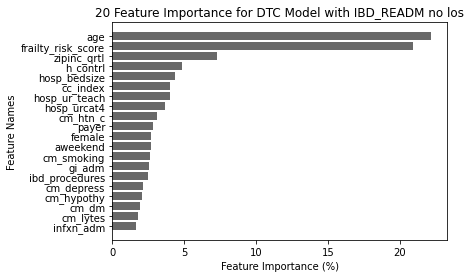

In [116]:
# Graph feature importance for Decision Tree Classifier
plt.barh([y[1] for y in dt_importance], [x[0]*100 for x in dt_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for DTC Model with IBD_READM no los')
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_Feature_Importance_20')
plt.show()

## XGBoost Classifier Model <a class="anchor" id="xgboostrfe"></a> 

## Target: HNHC <a class="anchor" id="xgbhnhc"></a>

[Return to Table of Contents](#contents)

In [117]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

earner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metr

In [118]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

hnhc_patients  steroid_use  age  los  orproc  payer  cm_alcohol  \
0                  0            0   89    4       0    1.0           0   
3                  0            0   48    4       1    2.0           0   
4                  1            0   65    5       0    1.0           0   
9                  0            0   51    3       1    2.0           0   
10                 0            0   22    6       1    1.0           0   
...              ...          ...  ...  ...     ...    ...         ...   
94491              0            0   32    3       0    2.0           0   
94492              0            0   54    4       1    2.0           0   
94493              1            0   44    9       1    2.0           0   
94496              0            0   52    2       1    1.0           0   
94497              0            0   72    4       0    1.0           0   

       cm_anemdef  cm_depress  cm_dmcx  cm_drug  cm_htn_c  cm_liver  cm_neuro  \
0               1           0        0        0         1         0         0   
3               0           0        0        0         0         0         0   
4               1           0        0        0         1         0         0   
9               0           0        0        0         0         0         0   
10              0           0        0        0         0         0         1   
...           ...         ...      ...      ...       ...       ...       ...   
94491           0           0        0        0         0         0         0   
94492           0           0        0        0         0         0         0   
94493           0           0        0        0         0         0         0   
94496           0           1        0        0         1         0         0   
94497           0           0        0        0         1         0         0   

       cm_wghtloss  blood_transfusion  cc_index  thromboses  chronic_pain  \
0                0                  0         2           0             0   
3                0                  0         0           0             0   
4                0                  0         0           0             0   
9                0                  0         0           0             0   
10               0                  0         0           0             0   
...            ...                ...       ...         ...           ...   
94491            0                  0         0           0             0   
94492            0                  0         0           0             0   
94493            0                  1         0           0             0   
94496            0                  0         2           0             0   
94497            0                  0         1           0             0   

       hosp_urcat4  ibd_specific_adm  
0                1                 0  
3                2                 1  
4                2                 1  
9                2                 0  
10               2                 0  
...            ...               ...  
94491            1                 0  
94492            1                 0  
94493            1                 1  
94496            2                 0  
94497            2                 1  

[47349 rows x 21 columns]

In [119]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47349, dtype: int64

In [120]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'age', 'los', 'orproc', 'payer', 'cm_alcohol',
       'cm_anemdef', 'cm_depress', 'cm_dmcx', 'cm_drug', 'cm_htn_c',
       'cm_liver', 'cm_neuro', 'cm_wghtloss', 'blood_transfusion', 'cc_index',
       'thromboses', 'chronic_pain', 'hosp_urcat4', 'ibd_specific_adm'],
      dtype='object')

In [121]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[19:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9323308270676691
Testing Score: 0.9164554823449907


In [122]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

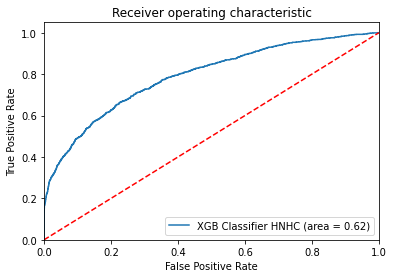

In [123]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_ROC_20')
plt.show()

In [124]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[19:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

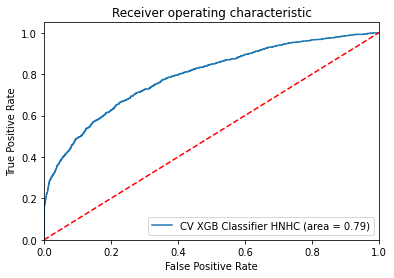

In [125]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_ROC_20')
plt.show()

In [126]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.033798043, 'cm_neuro'),
 (0.03485297, 'cm_alcohol'),
 (0.03541414, 'blood_transfusion'),
 (0.036271367, 'cm_depress'),
 (0.0366217, 'ibd_specific_adm'),
 (0.037528936, 'age'),
 (0.037571557, 'cm_htn_c'),
 (0.037589855, 'hosp_urcat4'),
 (0.038333107, 'cm_liver'),
 (0.03843452, 'cm_anemdef'),
 (0.038510874, 'cm_dmcx'),
 (0.03946374, 'cm_drug'),
 (0.03954827, 'cc_index'),
 (0.041158363, 'cm_wghtloss'),
 (0.0415645, 'steroid_use'),
 (0.04182589, 'chronic_pain'),
 (0.043765116, 'thromboses'),
 (0.045770947, 'payer'),
 (0.069854, 'orproc'),
 (0.23212206, 'los')]

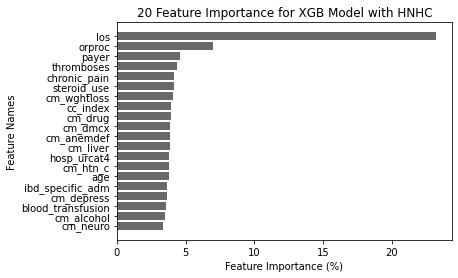

In [127]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for XGB Model with HNHC')
plt.savefig('images\XGB_Classifier_HNHC_Feature_Importance_20')
plt.show()

## Target: HNHC no 'los' <a class="anchor" id="xgbhnhcnolos"></a>

[Return to Table of Contents](#contents)

In [128]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_hnhc_no_los, target_hnhc)
columns_retained_RFE_log = cleaned_data_hnhc_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logist

In [129]:
# Create a data set with the selected features and split into target and feature set
features_list = ['hnhc_patients']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

hnhc_patients  steroid_use  age  elective  orproc  \
0                  0            0   89       0.0       0   
3                  0            0   48       1.0       1   
4                  1            0   65       0.0       0   
9                  0            0   51       0.0       1   
10                 0            0   22       1.0       1   
...              ...          ...  ...       ...     ...   
94491              0            0   32       0.0       0   
94492              0            0   54       1.0       1   
94493              1            0   44       1.0       1   
94496              0            0   52       1.0       1   
94497              0            0   72       0.0       0   

       hosp_urban_rural_location  payer  severe_IBD_hospitalization  cm_dmcx  \
0                              0    1.0                           0        0   
3                              0    2.0                           0        0   
4                              0    1.0                           0        0   
9                              0    2.0                           0        0   
10                             0    1.0                           0        0   
...                          ...    ...                         ...      ...   
94491                          0    2.0                           0        0   
94492                          0    2.0                           0        0   
94493                          0    2.0                           1        0   
94496                          0    1.0                           0        0   
94497                          0    1.0                           0        0   

       cm_drug  cm_neuro  cm_obese  cm_psych  cm_wghtloss  cm_smoking  \
0            0         0         0         0            0           1   
3            0         0         0         0            0           1   
4            0         0         0         0            0           1   
9            0         0         0         0            0           1   
10           0         1         0         0            0           0   
...        ...       ...       ...       ...          ...         ...   
94491        0         0         0         0            0           0   
94492        0         0         0         0            0           0   
94493        0         0         0         0            0           0   
94496        0         0         0         0            0           0   
94497        0         0         0         0            0           1   

       blood_transfusion  cc_index  thromboses  new_cdiff_adm  chronic_pain  \
0                      0         2           0              1             0   
3                      0         0           0              0             0   
4                      0         0           0              0             0   
9                      0         0           0              0             0   
10                     0         0           0              0             0   
...                  ...       ...         ...            ...           ...   
94491                  0         0           0              0             0   
94492                  0         0           0              0             0   
94493                  1         0           0              0             0   
94496                  0         2           0              0             0   
94497                  0         1           0              0             0   

       frailty_risk_score  
0                     4.7  
3                     0.5  
4                     5.7  
9                     2.8  
10                    3.8  
...                   ...  
94491                 0.0  
94492                 0.0  
94493                 0.0  
94496                 1.5  
94497                 4.7  

[47303 rows x 21 columns]

In [130]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["hnhc_patients"]
target_names_log = ["none", "hnhc"]
target_log  = target_log.astype('int64')
target_log 

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 47303, dtype: int64

In [131]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('hnhc_patients', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'age', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'severe_IBD_hospitalization', 'cm_dmcx', 'cm_drug', 'cm_neuro',
       'cm_obese', 'cm_psych', 'cm_wghtloss', 'cm_smoking',
       'blood_transfusion', 'cc_index', 'thromboses', 'new_cdiff_adm',
       'chronic_pain', 'frailty_risk_score'],
      dtype='object')

In [132]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[19:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.9273613890689743
Testing Score: 0.8970065956367326


In [133]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

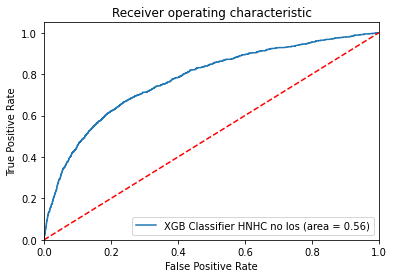

In [134]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier HNHC no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_HNHC_no_los_ROC_20')
plt.show()

In [135]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[19:18:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

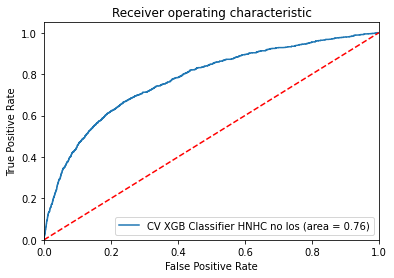

In [136]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier HNHC no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_HNHC_no_los_ROC_20')
plt.show()

In [137]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.02240672, 'elective'),
 (0.022852665, 'frailty_risk_score'),
 (0.023068117, 'cm_neuro'),
 (0.02327481, 'age'),
 (0.024444463, 'cm_smoking'),
 (0.02494155, 'cc_index'),
 (0.025295563, 'thromboses'),
 (0.025734868, 'steroid_use'),
 (0.025901616, 'cm_obese'),
 (0.026274733, 'cm_psych'),
 (0.028353762, 'hosp_urban_rural_location'),
 (0.02872254, 'cm_wghtloss'),
 (0.028961174, 'payer'),
 (0.030072387, 'chronic_pain'),
 (0.030302737, 'cm_dmcx'),
 (0.03117826, 'new_cdiff_adm'),
 (0.031346705, 'blood_transfusion'),
 (0.03542339, 'cm_drug'),
 (0.036107983, 'orproc'),
 (0.47533593, 'severe_IBD_hospitalization')]

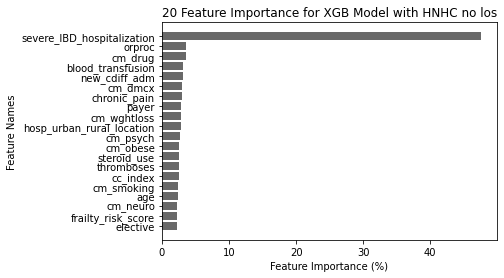

In [138]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for XGB Model with HNHC no los')
plt.savefig('images\XGB_Classifier_HNHC_no_los_Feature_Importance_20')
plt.show()

## Target: IBD_READM <a class="anchor" id="xgbreadm"></a>

[Return to Table of Contents](#contents)

In [139]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:

In [140]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

ibd_readm  steroid_use  abd_pain_adm  age  los  elective  orproc  \
0             1            0             0   89    4       0.0       0   
3             0            0             0   48    4       1.0       1   
4             1            0             0   65    5       0.0       0   
9             0            0             0   51    3       0.0       1   
10            0            0             0   22    6       1.0       1   
...         ...          ...           ...  ...  ...       ...     ...   
94491         0            0             0   32    3       0.0       0   
94492         0            0             0   54    4       1.0       1   
94493         1            0             0   44    9       1.0       1   
94496         0            0             0   52    2       1.0       1   
94497         0            0             0   72    4       0.0       0   

       hosp_urban_rural_location  payer  cm_anemdef  cm_depress  cm_dmcx  \
0                              0    1.0           1           0        0   
3                              0    2.0           0           0        0   
4                              0    1.0           1           0        0   
9                              0    2.0           0           0        0   
10                             0    1.0           0           0        0   
...                          ...    ...         ...         ...      ...   
94491                          0    2.0           0           0        0   
94492                          0    2.0           0           0        0   
94493                          0    2.0           0           0        0   
94496                          0    1.0           0           1        0   
94497                          0    1.0           0           0        0   

       cm_drug  ibd_procedures  cc_index  thromboses  new_cardiacarrest_adm  \
0            0               0         2           0                      0   
3            0               1         0           0                      0   
4            0               0         0           0                      0   
9            0               0         0           0                      0   
10           0               1         0           0                      0   
...        ...             ...       ...         ...                    ...   
94491        0               0         0           0                      0   
94492        0               1         0           0                      0   
94493        0               1         0           0                      0   
94496        0               0         2           0                      0   
94497        0               0         1           0                      0   

       new_septicemia_adm  chronic_pain  infxn_adm  ibd_specific_adm  
0                       0             0          1                 0  
3                       0             0          0                 1  
4                       0             0          0                 1  
9                       0             0          0                 0  
10                      0             0          0                 0  
...                   ...           ...        ...               ...  
94491                   0             0          0                 0  
94492                   0             0          0                 0  
94493                   0             0          0                 1  
94496                   0             0          0                 0  
94497                   0             0          0                 1  

[47303 rows x 21 columns]

In [141]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47303, dtype: int64

In [142]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'abd_pain_adm', 'age', 'los', 'elective', 'orproc',
       'hosp_urban_rural_location', 'payer', 'cm_anemdef', 'cm_depress',
       'cm_dmcx', 'cm_drug', 'ibd_procedures', 'cc_index', 'thromboses',
       'new_cardiacarrest_adm', 'new_septicemia_adm', 'chronic_pain',
       'infxn_adm', 'ibd_specific_adm'],
      dtype='object')

In [143]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[19:21:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.6857682442145615
Testing Score: 0.6144934889227127


In [144]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

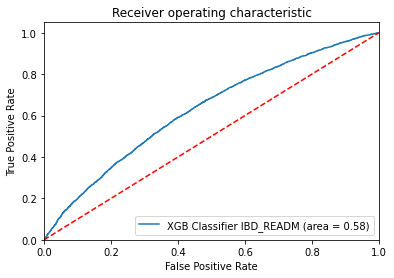

In [145]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_ROC_20')
plt.show()

In [146]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[19:21:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

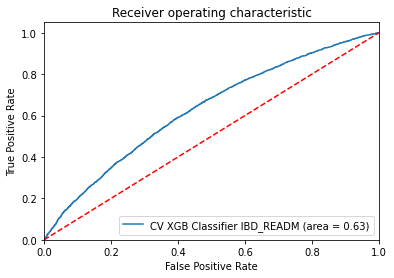

In [147]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_ROC_20')
plt.show()

In [148]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.032812692, 'new_cardiacarrest_adm'),
 (0.033506468, 'abd_pain_adm'),
 (0.03721892, 'age'),
 (0.038759083, 'hosp_urban_rural_location'),
 (0.03911219, 'infxn_adm'),
 (0.04026441, 'cm_depress'),
 (0.04065583, 'los'),
 (0.04264171, 'elective'),
 (0.044497017, 'cm_anemdef'),
 (0.04579194, 'ibd_procedures'),
 (0.047027033, 'cm_drug'),
 (0.047394373, 'cm_dmcx'),
 (0.04890912, 'new_septicemia_adm'),
 (0.049961668, 'cc_index'),
 (0.054506995, 'steroid_use'),
 (0.054669358, 'ibd_specific_adm'),
 (0.05495751, 'chronic_pain'),
 (0.055092897, 'thromboses'),
 (0.09524288, 'orproc'),
 (0.09697788, 'payer')]

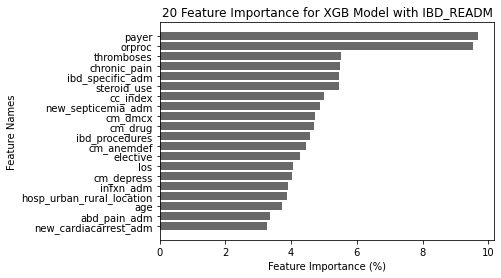

In [149]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for XGB Model with IBD_READM')
plt.savefig('images\XGB_Classifier_IBD_READM_Feature_Importance_20')
plt.show()

## Target: IBD_READM no 'los' <a class="anchor" id="xgbreadmnolos"></a>

[Return to Table of Contents](#contents)

In [150]:
# Use Recursive Feature Elimination (RFE) to select the 20 most important features with XGBoost Classifier

# XGBClassifier
from sklearn import  metrics, model_selection
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=42)

trans_log = RFE(model, n_features_to_select=20)
data_trans_log = trans_log.fit_transform(cleaned_data_wo_outcome_readmit_no_los, target_readmit)
columns_retained_RFE_log = cleaned_data_readmit_no_los.iloc[:, 1:].columns[trans_log.get_support()].values
print(columns_retained_RFE_log)

0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logis

In [151]:
# Create a data set with the selected features and split into target and feature set
features_list = ['ibd_readm']
features_list.extend(columns_retained_RFE_log)
data_log = readm_data_df[features_list]

cleaned_data_log = data_log.dropna(axis='rows')
cleaned_data_log

ibd_readm  steroid_use  age  elective  orproc  payer  \
0             1            0   89       0.0       0    1.0   
3             0            0   48       1.0       1    2.0   
4             1            0   65       0.0       0    1.0   
9             0            0   51       0.0       1    2.0   
10            0            0   22       1.0       1    1.0   
...         ...          ...  ...       ...     ...    ...   
94491         0            0   32       0.0       0    2.0   
94492         0            0   54       1.0       1    2.0   
94493         1            0   44       1.0       1    2.0   
94496         0            0   52       1.0       1    1.0   
94497         0            0   72       0.0       0    1.0   

       severe_IBD_hospitalization  cm_anemdef  cm_depress  cm_dmcx  cm_drug  \
0                               0           1           0        0        0   
3                               0           0           0        0        0   
4                               0           1           0        0        0   
9                               0           0           0        0        0   
10                              0           0           0        0        0   
...                           ...         ...         ...      ...      ...   
94491                           0           0           0        0        0   
94492                           0           0           0        0        0   
94493                           1           0           0        0        0   
94496                           0           0           1        0        0   
94497                           0           0           0        0        0   

       cm_psych  cm_wghtloss  blood_transfusion  ibd_procedures  cc_index  \
0             0            0                  0               0         2   
3             0            0                  0               1         0   
4             0            0                  0               0         0   
9             0            0                  0               0         0   
10            0            0                  0               1         0   
...         ...          ...                ...             ...       ...   
94491         0            0                  0               0         0   
94492         0            0                  0               1         0   
94493         0            0                  1               1         0   
94496         0            0                  0               0         2   
94497         0            0                  0               0         1   

       thromboses  new_septicemia_adm  new_cdiff_adm  chronic_pain  \
0               0                   0              1             0   
3               0                   0              0             0   
4               0                   0              0             0   
9               0                   0              0             0   
10              0                   0              0             0   
...           ...                 ...            ...           ...   
94491           0                   0              0             0   
94492           0                   0              0             0   
94493           0                   0              0             0   
94496           0                   0              0             0   
94497           0                   0              0             0   

       ibd_specific_adm  
0                     0  
3                     1  
4                     1  
9                     0  
10                    0  
...                 ...  
94491                 0  
94492                 0  
94493                 1  
94496                 0  
94497                 1  

[47303 rows x 21 columns]

In [152]:
# Grab outcome/label names after dropping na's/rows with na's
target_log = cleaned_data_log["ibd_readm"]
target_names_log = ["none", "ibd_readm"]
target_log  = target_log.astype('int64')
target_log 

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 47303, dtype: int64

In [153]:
# Grab feature names after dropping na's/rows with na
cleaned_data_wo_outcome_log = cleaned_data_log.drop('ibd_readm', axis=1)
featured_names_log = cleaned_data_wo_outcome_log.columns
featured_names_log

Index(['steroid_use', 'age', 'elective', 'orproc', 'payer',
       'severe_IBD_hospitalization', 'cm_anemdef', 'cm_depress', 'cm_dmcx',
       'cm_drug', 'cm_psych', 'cm_wghtloss', 'blood_transfusion',
       'ibd_procedures', 'cc_index', 'thromboses', 'new_septicemia_adm',
       'new_cdiff_adm', 'chronic_pain', 'ibd_specific_adm'],
      dtype='object')

In [154]:
# Initial model with XGBClassifier
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(cleaned_data_wo_outcome_log, target_log, random_state=42)

rf_log = XGBClassifier(random_state=42)

rf_log.fit(X_train_log, y_train_log)

print(f'Training Score: {rf_log.score(X_train_log, y_train_log)}')
print(f'Testing Score: {rf_log.score(X_test_log, y_test_log)}')

[19:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score: 0.688812470051019
Testing Score: 0.6099272788770506


In [155]:
# Creating ROC/AUC chart
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc_log_rf = roc_auc_score(y_test_log.values, rf_log.predict(X_test_log))
fpr_log_rf, tpr_log_rf, thresholds_log_rf = roc_curve(y_test_log.values, rf_log.predict_proba(X_test_log)[:,1])

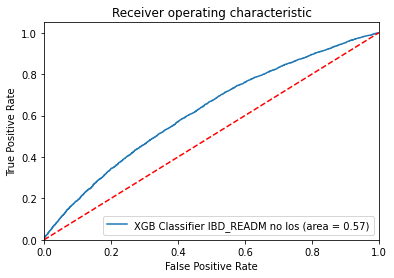

In [156]:
# Plotting the chart
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='XGB Classifier IBD_READM no los (area = %0.2f)' % rf_roc_auc_log_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_ROC_20')
plt.show()

In [157]:
# K-Fold Validation using XGBoost Classifier
clf_log_rf = XGBClassifier()

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

scores_log_rf = cross_validate(clf_log_rf, cleaned_data_wo_outcome_log, target_log, cv=10,
                        scoring=('roc_auc', 'precision','recall', 'accuracy'),
                        return_train_score=True)
print(scores_log_rf)

[19:24:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

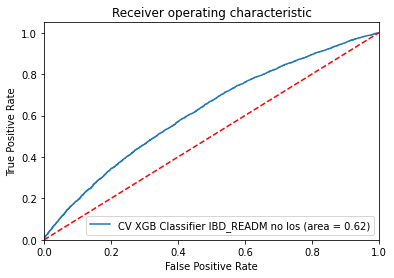

In [158]:
# Cross validated ROC/AUC chart
import matplotlib.pyplot as plt
from statistics import mean
plt.figure()
plt.plot(fpr_log_rf, tpr_log_rf, label='CV XGB Classifier IBD_READM no los (area = %0.2f)' % mean(scores_log_rf["test_roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\CV_XGB_Classifier_IBD_READM_no_los_ROC_20')
plt.show()

In [159]:
# Check the feature importance using XGBClassifier
lr_rf_importance = sorted(zip(rf_log.feature_importances_, X_train_log))
lr_rf_importance

[(0.036146156, 'cm_depress'),
 (0.037923437, 'age'),
 (0.038434185, 'blood_transfusion'),
 (0.03870101, 'cm_wghtloss'),
 (0.03876292, 'new_cdiff_adm'),
 (0.041290887, 'cm_anemdef'),
 (0.04143781, 'cm_psych'),
 (0.044206135, 'cm_dmcx'),
 (0.04628112, 'cm_drug'),
 (0.04691809, 'ibd_procedures'),
 (0.047151502, 'new_septicemia_adm'),
 (0.048286606, 'cc_index'),
 (0.050675403, 'chronic_pain'),
 (0.051383708, 'steroid_use'),
 (0.05192526, 'ibd_specific_adm'),
 (0.05215861, 'elective'),
 (0.059764896, 'thromboses'),
 (0.06149851, 'severe_IBD_hospitalization'),
 (0.07131736, 'orproc'),
 (0.09573641, 'payer')]

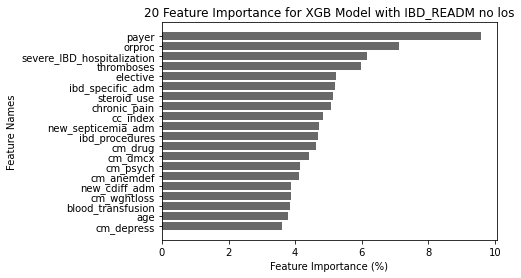

In [160]:
# Graph feature importance for XGBoost Classifier
plt.barh([y[1] for y in lr_rf_importance], [x[0]*100 for x in lr_rf_importance], color='dimgray')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature Names')
plt.title('20 Feature Importance for XGB Model with IBD_READM no los')
plt.savefig('images\XGB_Classifier_IBD_READM_no_los_Feature_Importance_20')
plt.show()